In [380]:
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import iqr
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time
from astropy.timeseries import LombScargle
from astropy.wcs import WCS
from astropy import units as u
from astropy.io import fits
from astropy import constants
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support

import missingno as missno
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [381]:
#Move up to RAFTS directory
if os.getcwd().endswith('/RAFTS'):
    pass
else:
    os.chdir('..')

In [382]:

from config import *

from utils import filt_interp, dpar, dtan, lamb_eff_md, dcr_offset, celest_to_pa, inverse_Teff, inverseTeff, inverseWeff, lorentzian, find_min_max_adjacent, variance_weighted_mean, chrDistAng
import globals

In [383]:
SAVE = False
D2ARCSEC = 3_600
DAY2SEC = 24 * 3_600


In [384]:
!pwd

/Users/fbianco/RAFTS


In [491]:
main_df = pd.read_csv("Outdata/main_df_oldPSF.csv")
main_df
main_df_new = pd.read_csv("Outdata/main_df_GaussPSF.csv")
main_df_new

id  group_id  group_size  local_bkg       x_init       y_init  \
0      1.0       1.0         1.0  32.860002   868.522296    21.285904   
1     67.0      67.0         1.0  22.824020   184.676236  2398.123898   
2     66.0      66.0         1.0  22.704307  1300.432535  2334.177144   
3     65.0      65.0         1.0  23.986071  1134.901937  2308.007500   
4     64.0      64.0         1.0  23.267743    89.050946  2290.185485   
...    ...       ...         ...        ...          ...          ...   
6655  25.0      25.0         1.0  30.836489  1711.013637  1002.334108   
6656  24.0      24.0         1.0  27.664921  1353.061647   945.537470   
6657  22.0      22.0         1.0  27.925559  1215.973622   926.975891   
6658  31.0      31.0         1.0  55.709088  1824.498209  1213.554383   
6659  92.0      99.0         1.0  26.774488  1943.813472  4081.788535   

          flux_init  x_fwhm_init  y_fwhm_init        x_fit  ...  y_fwhm_err  \
0     126752.984875          1.0          1.0   868.901854  ...    0.019373   
1       9088.540348          1.0          1.0   184.788578  ...    0.069575   
2       8039.251865          1.0          1.0  1300.538688  ...    0.136910   
3      11107.253667          1.0          1.0  1134.845481  ...    0.042059   
4       9862.451182          1.0          1.0    88.927061  ...    0.057909   
...             ...          ...          ...          ...  ...         ...   
6655   10776.370524          1.0          1.0  1713.230690  ...    0.240641   
6656   10435.065140          1.0          1.0  1356.854621  ...    0.095976   
6657    9584.155881          1.0          1.0  1216.566541  ...    0.140216   
6658   57115.466188          1.0          1.0  1824.834737  ...    0.092717   
6659    9163.110412          1.0          1.0  1943.875363  ...    0.211282   

      npixfit      qfit      cfit  flags         RA        DEC    RA_ERR  \
0       625.0  0.139842  0.001461    0.0  45.554966 -54.992271  0.000001   
1       625.0  0.798354  0.000974    0.0  45.856575 -54.940755  0.000004   
2       625.0  1.404182  0.001640    0.0  45.850447 -55.022310  0.000007   
3       625.0  0.446303  0.001646    0.0  45.846829 -55.010223  0.000002   
4       625.0  0.618064  0.001374    0.0  45.842770 -54.933839  0.000003   
...       ...       ...       ...    ...        ...        ...       ...   
6655    625.0  2.280585  0.001066    0.0  45.681360 -55.053572  0.000013   
6656    625.0  0.870087 -0.002466    0.0  45.673733 -55.027555  0.000005   
6657    625.0  1.549302 -0.004060    0.0  45.671096 -55.017312  0.000008   
6658    625.0  0.615803  0.000643    0.0  45.708521 -55.061596  0.000005   
6659    600.0  1.900898 -0.000842    1.0  46.074602 -55.067928  0.000012   

           DEC_ERR          time  
0     5.377676e-07  57374.240660  
1     1.952583e-06  57374.240660  
2     4.226357e-06  57374.240660  
3     1.151464e-06  57374.240660  
4     1.546420e-06  57374.240660  
...            ...           ...  
6655  6.532347e-06  57374.281315  
6656  2.499945e-06  57374.281315  
6657  3.804777e-06  57374.281315  
6658  2.426805e-06  57374.281315  
6659  5.644159e-06  57374.281315  

[6660 rows x 28 columns]

In [386]:
main_df_all = main_df.merge(main_df_new, suffixes=('_old', '_new'), left_on=('id', 'time'), right_on=('id', 'time'), how='outer')

In [392]:
flr_id = 11
FLAREINDX_ = flr_id - 1


<Axes: xlabel='time', ylabel='flux_fit'>

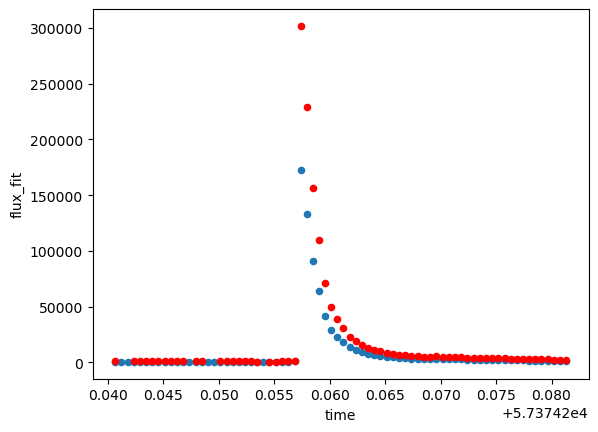

In [393]:
ax = main_df_new[main_df_new["id"] == flr_id].plot(x="time", y="flux_fit", kind='scatter')
main_df[main_df["id"] == flr_id].plot(x="time", y="flux_fit", ax=ax, kind='scatter', color='r')

In [394]:
main_df_all.shape

(7994, 49)

In [395]:
main_df_all = main_df_all.sort_values(["id", "time"])

In [398]:
main_df_all[main_df_all['id'] == flr_id]

Unnamed: 0    id  group_id_old  local_bkg_old  x_init_old  y_init_old  \
71          71.0  11.0          11.0      23.205445  320.609651  428.992096   
7328         NaN  11.0           NaN            NaN         NaN         NaN   
7343         NaN  11.0           NaN            NaN         NaN         NaN   
366        367.0  11.0          11.0      22.622928  320.445774  429.464169   
473        473.0  11.0          13.0      21.484964  320.963110  428.407932   
...          ...   ...           ...            ...         ...         ...   
6910      6894.0  11.0          11.0      26.651665  320.227083  427.290883   
6990      6989.0  11.0          11.0      26.684314  320.357455  428.162025   
7095      7074.0  11.0          11.0      26.834987  319.850318  427.045720   
7181      7169.0  11.0          11.0      26.829193  319.657690  427.766516   
7284      7263.0  11.0          12.0      26.711660  318.718544  427.778942   

      flux_init_old   x_fit_old   y_fit_old  flux_fit_old  ...  x_fwhm_err  \
71      2376.580928  320.632378  429.042347   1027.231919  ...    0.179559   
7328            NaN         NaN         NaN           NaN  ...    0.179818   
7343            NaN         NaN         NaN           NaN  ...    0.205100   
366     2314.052575  320.231374  429.698961   1011.509538  ...    0.207228   
473     2389.650484  320.817316  428.605051   1379.440040  ...    0.168039   
...             ...         ...         ...           ...  ...         ...   
6910    3545.589688  320.243422  427.547101   2777.467436  ...    0.099335   
6990    3440.164793  320.296185  428.493803   2725.231354  ...    0.123510   
7095    3529.139337  319.850625  427.365180   2651.361680  ...    0.091472   
7181    3504.598482  319.693049  428.008806   2582.148306  ...    0.084221   
7284    3525.253244  318.682218  427.906235   2667.673937  ...    0.091714   

      y_fwhm_err  npixfit_new  qfit_new  cfit_new  flags_new     RA_new  \
71      0.203067        625.0  2.282709 -0.000852        0.0  45.606318   
7328    0.161823        625.0  2.354183 -0.000825        0.0  45.606329   
7343    0.197335        625.0  2.575127  0.006711        0.0  45.606323   
366     0.203305        625.0  2.252085 -0.000328        0.0  45.606323   
473     0.180133        625.0  2.038953  0.006879        0.0  45.606343   
...          ...          ...       ...       ...        ...        ...   
6910    0.117238        625.0  0.897742 -0.002499        0.0  45.606336   
6990    0.146859        625.0  0.888011  0.003106        0.0  45.606341   
7095    0.107945        625.0  0.926320  0.003233        0.0  45.606334   
7181    0.095835        625.0  0.975837  0.008874        0.0  45.606369   
7284    0.105874        625.0  0.929703  0.001504        0.0  45.606352   

        DEC_new  RA_ERR_new  DEC_ERR_new  
71   -54.951988    0.000011     0.000005  
7328 -54.952008    0.000009     0.000005  
7343 -54.951993    0.000011     0.000006  
366  -54.951994    0.000011     0.000006  
473  -54.951993    0.000010     0.000005  
...         ...         ...          ...  
6910 -54.951995    0.000006     0.000003  
6990 -54.951996    0.000008     0.000004  
7095 -54.951990    0.000006     0.000003  
7181 -54.951996    0.000005     0.000003  
7284 -54.951988    0.000006     0.000003  

[74 rows x 49 columns]

In [400]:
main_df_all['id'].unique().shape

(110,)

In [401]:
t_index = []
for i, time in enumerate(main_df_all['time'].dropna().unique()):

    if (main_df_all['time'][main_df_all['id'] == flr_id].values == time).any():
        t_index.append(True)

    else:
        t_index.append(False) 

In [402]:
NDPS = len(t_index)
NDPS

74

(110,)

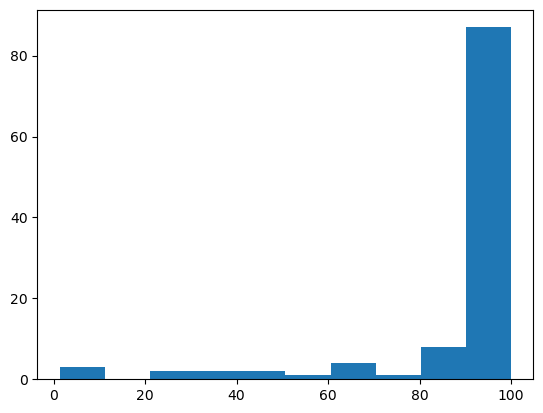

In [403]:
m = []

for id in main_df['id'].unique():
    m.append((main_df[main_df['id'] == id].shape[0] / NDPS) * 100)

m = np.array(m)
plt.hist(m)
m.shape

In [404]:
len(m[m == 100.0]) #what is thhis?

49

In [405]:
len(m[m > 80])  #what is thhis?

95

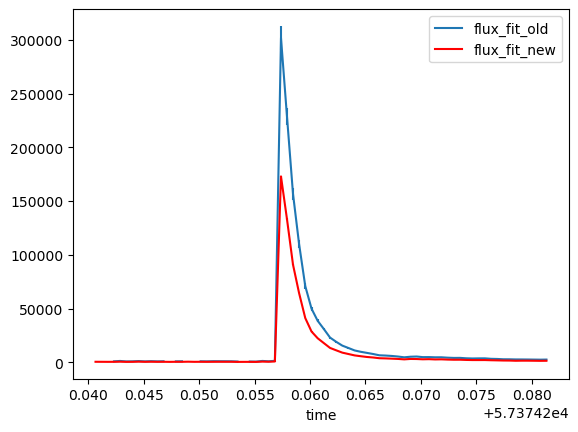

In [407]:
ax = main_df_all[main_df_all['id'] == flr_id].plot(x = 'time', y='flux_fit_old', yerr='flux_err_old');
main_df_all[main_df_all['id'] == flr_id].plot(x = 'time', y='flux_fit_new', yerr='flux_err_new', ax=ax, color='r');

In [408]:
main_df_all[main_df_all['id'] == flr_id][["flux_fit_new","flux_fit_old",'time']]#.dropna(how="any")

flux_fit_new  flux_fit_old          time
71      610.886861   1027.231919  57374.240660
7328    583.807191           NaN  57374.241217
7343    550.645092           NaN  57374.241772
366     575.470152   1011.509538  57374.242328
473     693.382134   1379.440040  57374.242878
...            ...           ...           ...
6910   1639.451263   2777.467436  57374.279094
6990   1632.843675   2725.231354  57374.279650
7095   1565.924068   2651.361680  57374.280204
7181   1496.422752   2582.148306  57374.280761
7284   1541.935755   2667.673937  57374.281315

[74 rows x 3 columns]

In [409]:
g_flux = {}
g_flux["old"] = main_df_all[main_df_all['id'] == flr_id]['flux_fit_old']
g_flux_err["old"] = main_df_all[main_df_all['id'] == flr_id]['flux_err_old']
flr_times["old"] = main_df_all[main_df_all['id'] == flr_id]['time']

g_flux["new"] = main_df_all[main_df_all['id'] == flr_id]['flux_fit_new']
g_flux_err["new"] = main_df_all[main_df_all['id'] == flr_id]['flux_err_new']
flr_times["new"] = main_df_all[main_df_all['id'] == flr_id]['time']
g_flux["old"]

71      1027.231919
7328            NaN
7343            NaN
366     1011.509538
473     1379.440040
           ...     
6910    2777.467436
6990    2725.231354
7095    2651.361680
7181    2582.148306
7284    2667.673937
Name: flux_fit_old, Length: 74, dtype: float64

In [410]:
g_mag = {}
g_mag["new"] = 22.5 - 2.5 * np.log10(g_flux["new"].values)
g_mag_err = {}
g_mag_err["new"] = (2.5/np.log(10)) * (g_flux_err["new"]/g_flux["new"])
g_mag_err["new"] = g_mag_err["new"].values

delta_g_mag = {}
delta_g_mag_err = {}
delta_g_mag["new"] = g_mag["new"] - np.mean(g_mag["new"][((
    flr_times["new"] - flr_times["new"].iloc[0]) * DAY2SEC) < 1000])
delta_g_mag_err["new"] = g_mag_err["new"] #- np.sqrt(np.sum(g_mag_err["new"][((
    #flr_times["new"] - flr_times["new"].iloc[0]) * DAY2SEC) < 1000] ** 2)) /  len(g_mag_err["new"][((
    #flr_times["new"] - flr_times["new"].iloc[0]) * DAY2SEC) < 1000])


for i, t in enumerate(t_index):
    if not t:
        delta_g_mag["new"] = np.insert(delta_g_mag["new"], i, np.nan)
        delta_g_mag_err["new"] = np.insert(delta_g_mag_err["new"], i, np.nan)
    else:
        pass

delta_g_mag["new"], delta_g_mag_err["new"]

(array([-1.49826501e-02,  3.42457107e-02,  9.77398808e-02,  4.98623036e-02,
        -1.52512306e-01,  1.07702992e-01,  4.56531675e-02, -2.05019648e-01,
         3.86512265e-02, -1.05795984e-01,  3.39218237e-02, -4.05074251e-03,
         1.42198811e-01,  3.21401166e-03,  4.54631841e-02, -1.46372447e-01,
         7.49691470e-02, -2.17013694e-02,  4.49035675e-02, -8.35786510e-03,
        -5.97328136e-02, -2.64876925e-02, -3.96580719e-02,  1.92819580e-01,
         1.41137351e-01,  1.17692399e-01,  1.89670997e-01, -2.71239917e-01,
        -8.18469880e-02, -4.20850085e-01, -6.14484409e+00, -5.86251294e+00,
        -5.44668668e+00, -5.07371232e+00, -4.58853684e+00, -4.19547546e+00,
        -3.92998651e+00, -3.69052755e+00, -3.37419517e+00, -3.17987341e+00,
        -2.94892348e+00, -2.78228763e+00, -2.58707409e+00, -2.45435215e+00,
        -2.31388740e+00, -2.20412547e+00, -2.03291660e+00, -1.98747049e+00,
        -1.91614756e+00, -1.83303918e+00, -1.68637052e+00, -1.82587080e+00,
        -1.8

In [411]:
g_mag["old"] = 22.5 - 2.5 * np.log10(g_flux["old"].values)
g_mag_err["old"] = (2.5/np.log(10)) * (g_flux_err["old"]/g_flux["old"])
g_mag_err["old"] = g_mag_err["old"].values
delta_g_mag["old"] = g_mag["old"] - np.nanmean(g_mag["old"][((
    flr_times["old"] - flr_times["old"].iloc[0]) * DAY2SEC) < 1000])
delta_g_mag_err["old"] = g_mag_err["old"] #- np.sqrt(np.nansum(g_mag_err["old"][((
    #flr_times["old"] - flr_times["old"].iloc[0]) * DAY2SEC) < 1000] ** 2)) /  len(g_mag_err["old"][((
    #flr_times["old"] - flr_times["old"].iloc[0]) * DAY2SEC) < 1000])


for i, t in enumerate(t_index):
    if not t:
        delta_g_mag["old"] = np.insert(delta_g_mag["old"], i, np.nan)
        delta_g_mag_err["old"] = np.insert(delta_g_mag_err["old"], i, np.nan)
    else:
        pass

g_mag_err["old"], delta_g_mag["old"], delta_g_mag_err["old"]

(array([0.06218841,        nan,        nan, 0.06447035, 0.04800366,
        0.07245057, 0.06506925, 0.05184815, 0.06812078, 0.05896789,
        0.06871207, 0.06637776,        nan, 0.07042501, 0.06450843,
               nan,        nan, 0.06119903, 0.07223715, 0.05849731,
        0.06118261, 0.06358549, 0.06546366, 0.09219227,        nan,
        0.08795861, 0.0993785 , 0.04905163, 0.07187528, 0.06380379,
        0.0398934 , 0.03774134, 0.03907471, 0.03933554, 0.03836938,
        0.03967522, 0.03960863, 0.03835046, 0.04378571, 0.041352  ,
        0.04388596, 0.04057639, 0.04249144, 0.04156089, 0.0419542 ,
        0.04174981, 0.04458794, 0.0417664 , 0.04337123, 0.04616294,
        0.04621172, 0.04385773, 0.04409819, 0.04716973, 0.04812818,
        0.04632895, 0.04412866, 0.04802966, 0.05167287, 0.0455945 ,
        0.05041605, 0.04941537, 0.04710358, 0.04210237, 0.04894236,
        0.04962144, 0.05137293, 0.05235105, 0.05239886, 0.04807391,
        0.04609365, 0.04717585, 0.04898544, 0.04

In [412]:
flr_id

11

In [413]:
len(delta_g_mag)

2

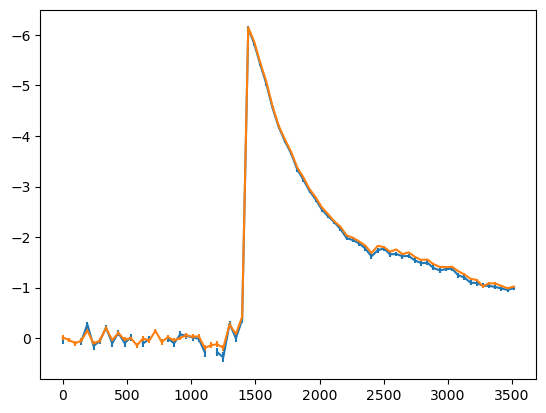

In [414]:
times = main_df['time'].dropna().unique() 
# you were doing this subtraction and the conversion to second 50 times and then you were creating this variable way below...
tSec = (times - times[0]) * DAY2SEC
plt.errorbar(tSec, delta_g_mag['old'], yerr=delta_g_mag_err['old'])
plt.errorbar(tSec, delta_g_mag['new'], yerr=delta_g_mag_err['new'])
plt.gca().invert_yaxis()

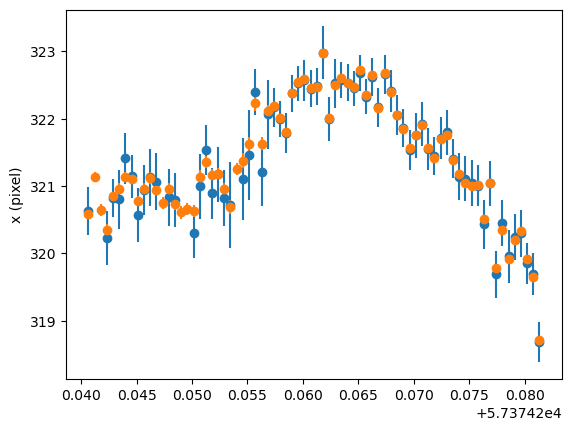

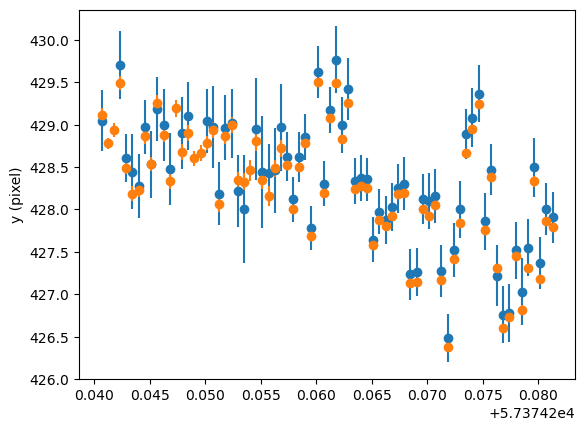

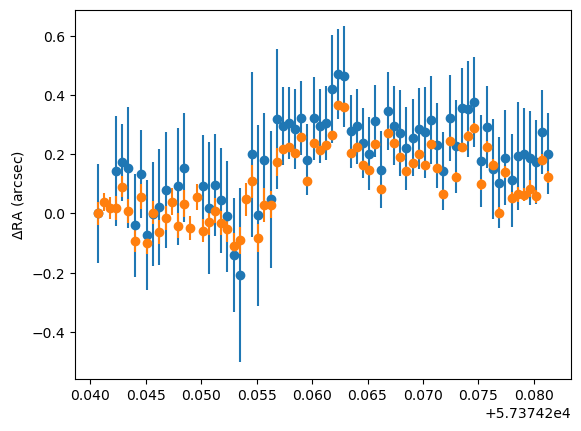

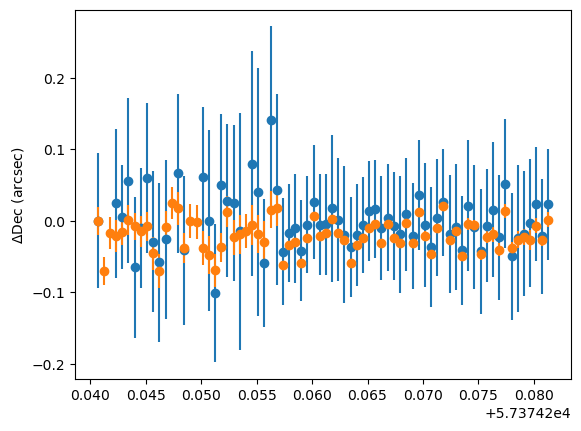

In [415]:
plt.errorbar(main_df_all['time'][main_df_all['id'] == flr_id], main_df_all['x_fit_old'][main_df_all['id'] == flr_id], 
             yerr = main_df_all['x_err_old'][main_df_all['id'] == flr_id], marker='o', ls='None')
plt.errorbar(main_df_all['time'][main_df_all['id'] == flr_id], 
             main_df_all['x_fit_new'][main_df_all['id'] == flr_id], 
             yerr = main_df_all['x_err_new'][main_df_all['id'] == flr_id], marker='o', ls='None')
plt.ylabel('x (pixel)')

plt.show()

plt.errorbar(main_df_all['time'][main_df_all['id'] == flr_id], 
             main_df_all['y_fit_old'][main_df_all['id'] == flr_id], 
             yerr = main_df_all['y_err_old'][main_df_all['id'] == flr_id], marker='o', ls='None')
plt.errorbar(main_df_all['time'][main_df_all['id'] == flr_id], 
             main_df_all['y_fit_new'][main_df_all['id'] == flr_id], 
             yerr = main_df_all['y_err_new'][main_df_all['id'] == flr_id], marker='o', ls='None')
plt.ylabel('y (pixel)')
plt.show()

plt.errorbar(main_df_all['time'][main_df_all['id'] == flr_id], (
    main_df_all['RA_old'][main_df_all['id'] == flr_id] - main_df_all['RA_old'][main_df_all['id'] == flr_id].iloc[0]) * D2ARCSEC, 
             yerr = main_df_all['RA_ERR_old'][main_df_all['id'] == flr_id] * D2ARCSEC, marker='o', ls='None')
plt.errorbar(main_df_all['time'][main_df_all['id'] == flr_id], (
    main_df_all['RA_new'][main_df_all['id'] == flr_id] - main_df_all['RA_new'][main_df_all['id'] == flr_id].iloc[0]) * D2ARCSEC, 
             yerr = main_df_all['RA_ERR_new'][main_df_all['id'] == flr_id] * D2ARCSEC, marker='o', ls='None')
plt.ylabel(r'$\Delta$RA (arcsec)')
plt.show()

plt.errorbar(main_df_all['time'][main_df_all['id'] == flr_id], (
    main_df_all['DEC_old'][main_df_all['id'] == flr_id] - main_df_all['DEC_old'][main_df_all['id'] == flr_id].iloc[0]) * D2ARCSEC, 
             yerr = main_df_all['DEC_ERR_old'][main_df_all['id'] == flr_id] * D2ARCSEC, marker='o', ls='None')
plt.errorbar(main_df_all['time'][main_df_all['id'] == flr_id], (
    main_df_all['DEC_new'][main_df_all['id'] == flr_id] - main_df_all['DEC_new'][main_df_all['id'] == flr_id].iloc[0]) * D2ARCSEC, 
             yerr = main_df_all['DEC_ERR_new'][main_df_all['id'] == flr_id] * D2ARCSEC, marker='o', ls='None')
plt.ylabel(r'$\Delta$Dec (arcsec)')
plt.show()


<Axes: >

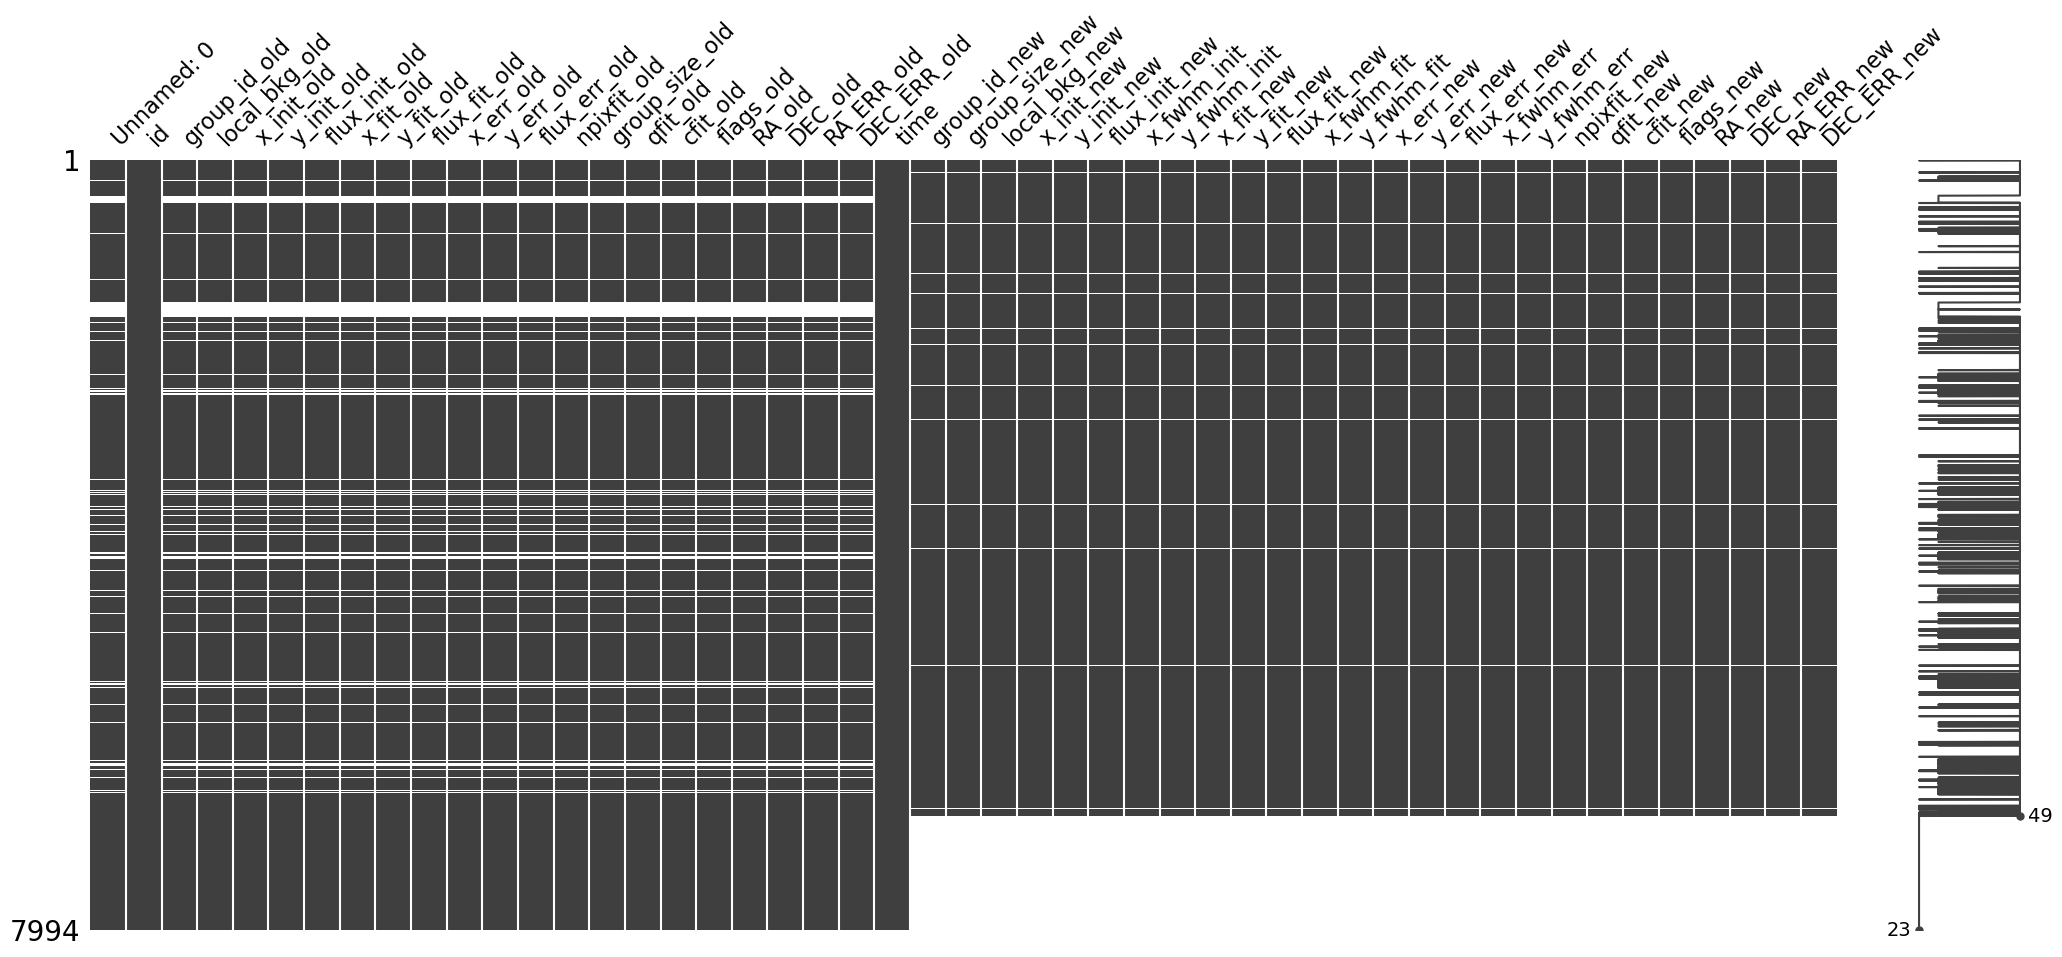

In [416]:
missno.matrix(main_df_all)

In [417]:
main_df_all.columns

Index(['Unnamed: 0', 'id', 'group_id_old', 'local_bkg_old', 'x_init_old',
       'y_init_old', 'flux_init_old', 'x_fit_old', 'y_fit_old', 'flux_fit_old',
       'x_err_old', 'y_err_old', 'flux_err_old', 'npixfit_old',
       'group_size_old', 'qfit_old', 'cfit_old', 'flags_old', 'RA_old',
       'DEC_old', 'RA_ERR_old', 'DEC_ERR_old', 'time', 'group_id_new',
       'group_size_new', 'local_bkg_new', 'x_init_new', 'y_init_new',
       'flux_init_new', 'x_fwhm_init', 'y_fwhm_init', 'x_fit_new', 'y_fit_new',
       'flux_fit_new', 'x_fwhm_fit', 'y_fwhm_fit', 'x_err_new', 'y_err_new',
       'flux_err_new', 'x_fwhm_err', 'y_fwhm_err', 'npixfit_new', 'qfit_new',
       'cfit_new', 'flags_new', 'RA_new', 'DEC_new', 'RA_ERR_new',
       'DEC_ERR_new'],
      dtype='object')

In [418]:
# FBB cleaning maindf 
main_df_all = main_df_all.dropna(how="all")


In [419]:
# FBB moved here because it uses main_df - soon you will make arrays and can use only ghose
#airmass of flare object at all epochs
flr_am = SkyCoord(ra = main_df_all['RA_new'][main_df_all['id'] == flr_id], dec = main_df_all['DEC_new'][main_df_all['id'] == flr_id], 
         unit=u.deg, obstime=Time(main_df_all['time'][main_df_all['id'] == flr_id].values, format='mjd'), 
                  location=EarthLocation.of_site('Cerro Tololo')).transform_to(AltAz).secz.value

flr_am.min(), flr_am.max(), 

(1.4607134302405007, 1.752918955119076)

In [420]:
#epochs when the flare star is observed
dt_sec = (main_df_all['time'][main_df_all['id'] == flr_id] - main_df_all['time'][main_df_all['id'] == flr_id].iloc[0]) * DAY2SEC
print(f"Epochs with flare star detections: {dt_sec.shape[0]}")

Epochs with flare star detections: 74


In [421]:
if SAVE:
    np.save('Outdata/dt_sec.npy', dt_sec)

### getting RA and Dec for each star and time tamp into an array

In [422]:
NStars = main_df_all['id'].dropna().unique().shape[0]
print(f"number of stars {NStars}")

number of stars 110


In [423]:
ras = {}
ras["new"] = np.zeros((NDPS, NStars)) #74 time stamps, 110 stars RA in deg
ras["old"] = np.zeros((NDPS, NStars)) #74 time stamps, 110 stars RA in deg
decs = {}
decs["new"] = np.zeros((NDPS, NStars)) #74 time stamps, 110 stars Dec in deg
decs["old"] = np.zeros((NDPS, NStars)) #74 time stamps, 110 stars Dec in deg

for j, id in (enumerate(np.sort(main_df_all['id'].dropna().unique()))): #for every star
    print(f"star id {j}")
    for i, t in (enumerate(main_df_all['time'].dropna().unique())): #for every time stamp
        if j == 48 or j == 49:
            print(f"time {t}")
        if main_df_all['RA_new'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values.any():
            ras["new"][i,j] = main_df_all['RA_new'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values[0]
            decs["new"][i,j] = main_df_all['DEC_new'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values[0]
        else:
            ras["new"][i,j] = np.nan
            decs["new"][i,j] = np.nan
        if main_df_all['RA_old'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values.any():
            ras["old"][i,j] = main_df_all['RA_old'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values[0]
            decs["old"][i,j] = main_df_all['DEC_old'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values[0]
        else:
            ras["old"][i,j] = np.nan
            decs["old"][i,j] = np.nan
            

star id 0
star id 1
star id 2
star id 3
star id 4
star id 5
star id 6
star id 7
star id 8
star id 9
star id 10
star id 11
star id 12
star id 13
star id 14
star id 15
star id 16
star id 17
star id 18
star id 19
star id 20
star id 21
star id 22
star id 23
star id 24
star id 25
star id 26
star id 27
star id 28
star id 29
star id 30
star id 31
star id 32
star id 33
star id 34
star id 35
star id 36
star id 37
star id 38
star id 39
star id 40
star id 41
star id 42
star id 43
star id 44
star id 45
star id 46
star id 47
star id 48
time 57374.24065968833
time 57374.24121741996
time 57374.24177234031
time 57374.242327586275
time 57374.2428775539
time 57374.243432107214
time 57374.24399959874
time 57374.244556535
time 57374.24512304739
time 57374.24566513418
time 57374.246237897605
time 57374.24679229859
time 57374.24734976024
time 57374.24790304527
time 57374.24845713339
time 57374.249015232665
time 57374.24958296006
time 57374.250139535165
time 57374.250695473034
time 57374.251252728885
time 57

### getting RA and Dec uncertainties for each star and time tamp into an array

In [424]:
raerrs = {}
decerrs = {}
raerrs["new"] = np.zeros((NDPS, 110)) # error 74 time stamps 110 stars RA uncertainties in deg
raerrs["old"] = np.zeros((NDPS, 110)) # error 74 time stamps 110 stars RA uncertainties in deg
decerrs["new"] = np.zeros((NDPS, 110)) # error 74 time stamps 110 stars Dec uncertainties in deg
decerrs["old"] = np.zeros((NDPS, 110)) # error 74 time stamps 110 stars Dec uncertainties in deg

# FBB you could avoid he for loop with the "in" syntax but ok
for j, id in (enumerate(np.sort(main_df_all['id'].dropna().unique()))): #for every star
    print(f"star id {j}")
    for i, t in (enumerate(main_df_all['time'].dropna().unique())): #for every time stamp
        if (main_df_all['RA_ERR_new'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values).any():
            raerrs["new"][i,j] = main_df_all['RA_ERR_new'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values[0]
            decerrs["new"][i,j] = main_df_all['DEC_ERR_new'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values[0] 
        else:
            raerrs["new"][i,j] = np.nan
            decerrs["new"][i,j] = np.nan
        if (main_df_all['RA_ERR_old'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values).any():
            raerrs["old"][i,j] = main_df_all['RA_ERR_old'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values[0]
            decerrs["old"][i,j] = main_df_all['DEC_ERR_old'][(main_df_all['id'] == id) * (main_df_all['time'] == t)].dropna().values[0] 

        else:
            raerrs["old"][i,j] = np.nan
            decerrs["old"][i,j] = np.nan


star id 0
star id 1
star id 2
star id 3
star id 4
star id 5
star id 6
star id 7
star id 8
star id 9
star id 10
star id 11
star id 12
star id 13
star id 14
star id 15
star id 16
star id 17
star id 18
star id 19
star id 20
star id 21
star id 22
star id 23
star id 24
star id 25
star id 26
star id 27
star id 28
star id 29
star id 30
star id 31
star id 32
star id 33
star id 34
star id 35
star id 36
star id 37
star id 38
star id 39
star id 40
star id 41
star id 42
star id 43
star id 44
star id 45
star id 46
star id 47
star id 48
star id 49
star id 50
star id 51
star id 52
star id 53
star id 54
star id 55
star id 56
star id 57
star id 58
star id 59
star id 60
star id 61
star id 62
star id 63
star id 64
star id 65
star id 66
star id 67
star id 68
star id 69
star id 70
star id 71
star id 72
star id 73
star id 74
star id 75
star id 76
star id 77
star id 78
star id 79
star id 80
star id 81
star id 82
star id 83
star id 84
star id 85
star id 86
star id 87
star id 88
star id 89
star id 90
star id 9

errors in RA and DEC are suspiciously similar... FBB does not understand why really


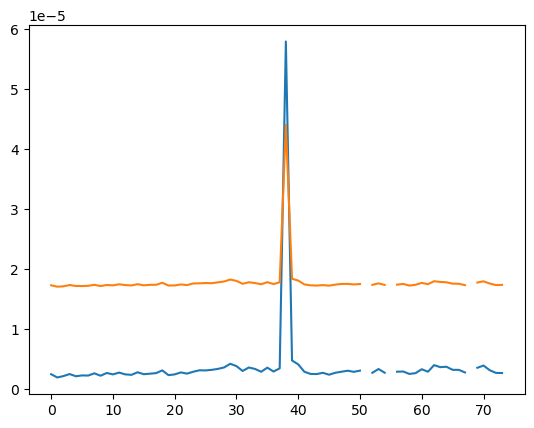

In [425]:
plt.plot(raerrs["new"][:,9])
plt.plot(decerrs["new"][:,9] + 1.6e-5)
print("errors in RA and DEC are suspiciously similar... FBB does not understand why really")

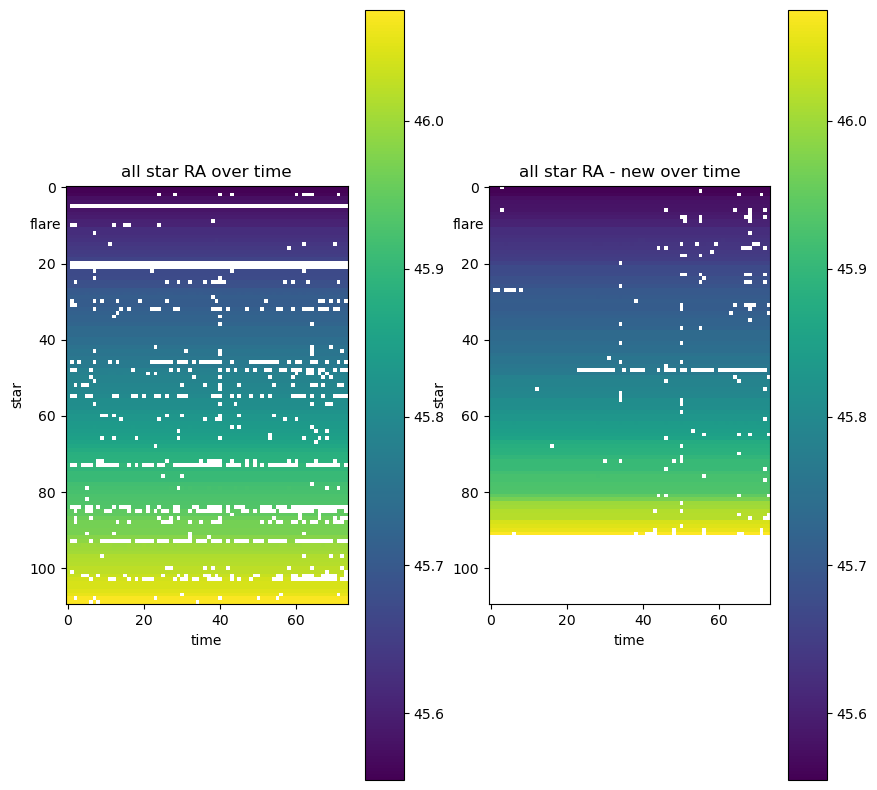

In [426]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(ras["old"].T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star RA over time")
axs[0].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(ras["new"].T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")

plt.colorbar(cb);
axs[1].set_title("all star RA - new over time");


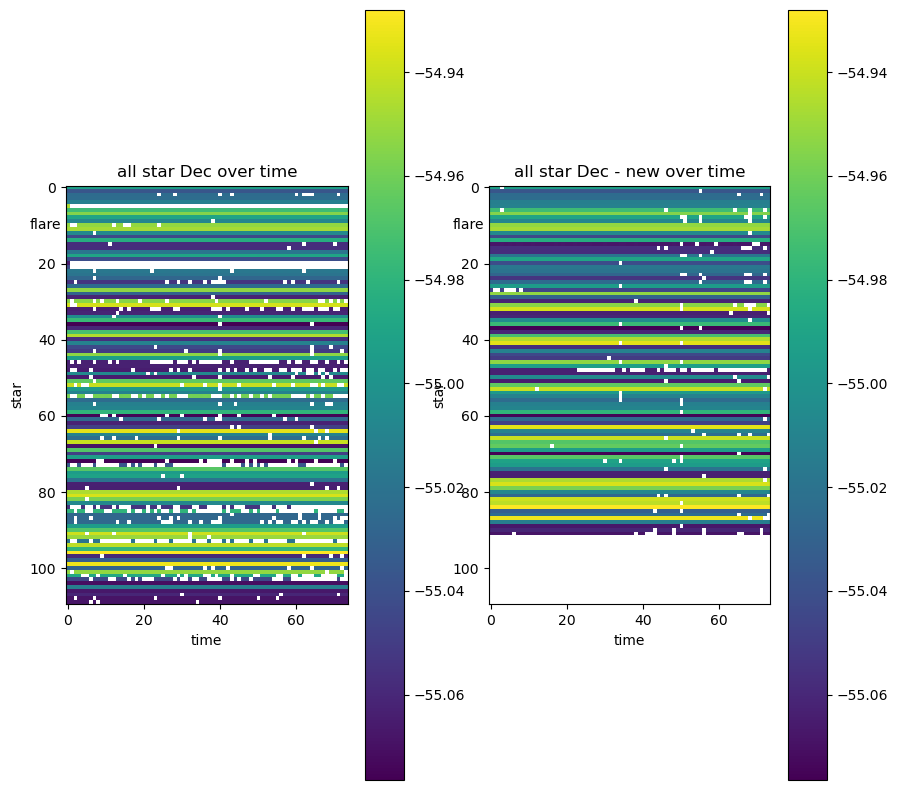

In [427]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(decs["old"].T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star Dec over time")
axs[0].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(decs["new"].T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")

plt.colorbar(cb);
axs[1].set_title("all star Dec - new over time");

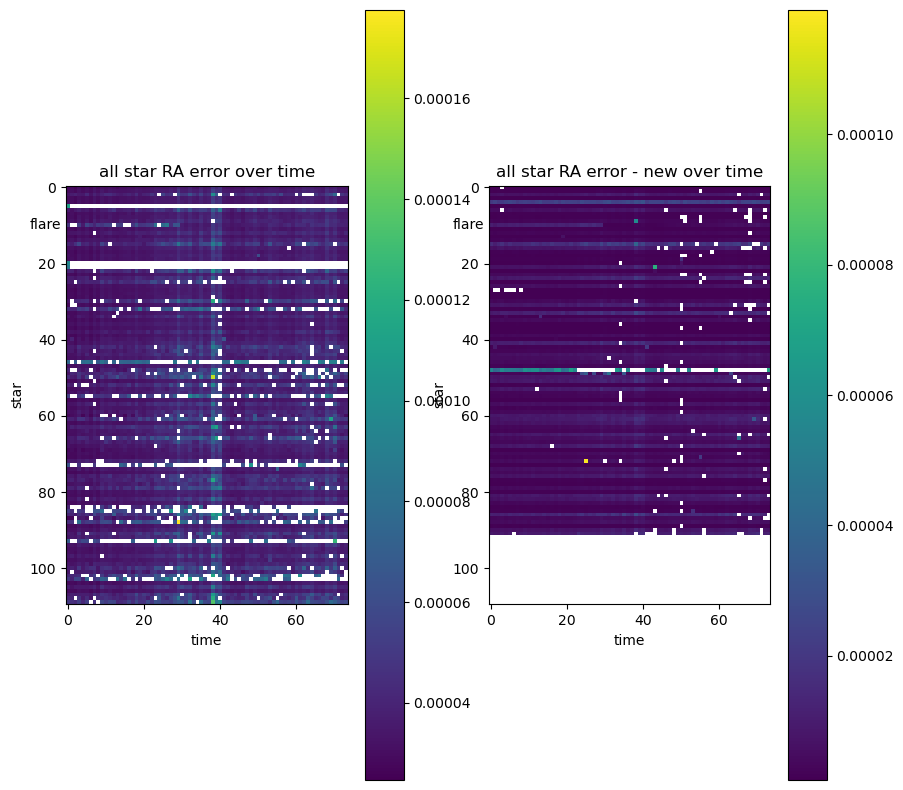

In [428]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(raerrs["old"].T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star RA error over time")
axs[0].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(raerrs["new"].T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")

plt.colorbar(cb);
axs[1].set_title("all star RA error - new over time");


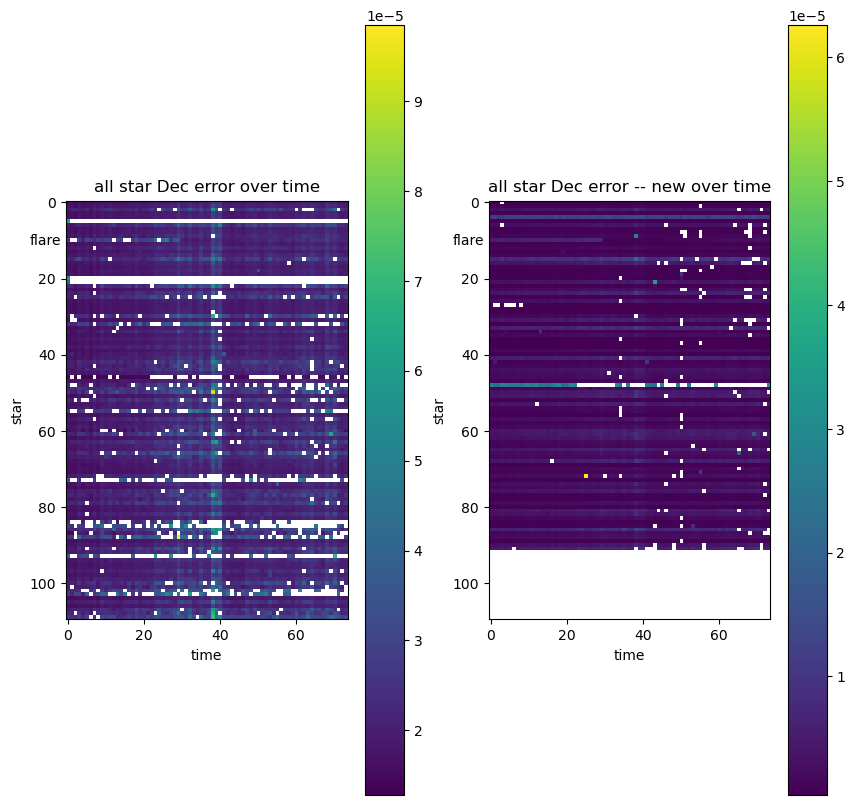

In [429]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(decerrs["old"].T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star Dec error over time")
axs[0].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(decerrs["new"].T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")

plt.colorbar(cb);
axs[1].set_title("all star Dec error -- new over time");


### relative position for each star (compared to first time stamp)

In [430]:
# FBB moved here and used throughout instead of repeatedly subtracting the last epoch. Also this is a vectorizable operation! no need for for loop
#FBB convert to arcsec here once and for all isntead of redoing below a bunch of times
shift_ras = {}
shift_decs = {}
shift_ras["new"] = (ras["new"] - ras["new"][0,:]) * D2ARCSEC# in arcsec
shift_decs["new"] = (decs["new"] - decs["new"][0,:]) * D2ARCSEC# in arcsec
shift_ras["old"] = (ras["old"] - ras["old"][0,:]) * D2ARCSEC# in arcsec
shift_decs["old"] = (decs["old"] - decs["old"][0,:]) * D2ARCSEC# in arcsec

shift_ras["new"].shape, shift_decs["new"].shape, shift_ras["old"].shape, shift_decs["old"].shape

((74, 110), (74, 110), (74, 110), (74, 110))

### uncertainty in arcsec for each star (compared to first time stamp)

In [431]:
# FBB I think you do not need to add the error in quadrature because you just want to have a reference? 
shift_raerrs = {}
shift_decerrs = {}
shift_raerrs["new"] = raerrs["new"] * D2ARCSEC #np.sqrt(raerrs **2 + raerrs[0,:] **2) * D2ARCSEC
shift_decerrs["new"] = decerrs["new"] * D2ARCSEC #np.sqrt(decerrs**2 +  decerrs[0,:]**2) * D2ARCSEC
shift_raerrs["old"] = raerrs["old"] * D2ARCSEC #np.sqrt(raerrs **2 + raerrs[0,:] **2) * D2ARCSEC
shift_decerrs["old"] = decerrs["old"] * D2ARCSEC #np.sqrt(decerrs**2 +  decerrs[0,:]**2) * D2ARCSEC

shift_raerrs["new"].shape, shift_decerrs["new"].shape, shift_raerrs["old"].shape, shift_decerrs["old"].shape

((74, 110), (74, 110), (74, 110), (74, 110))

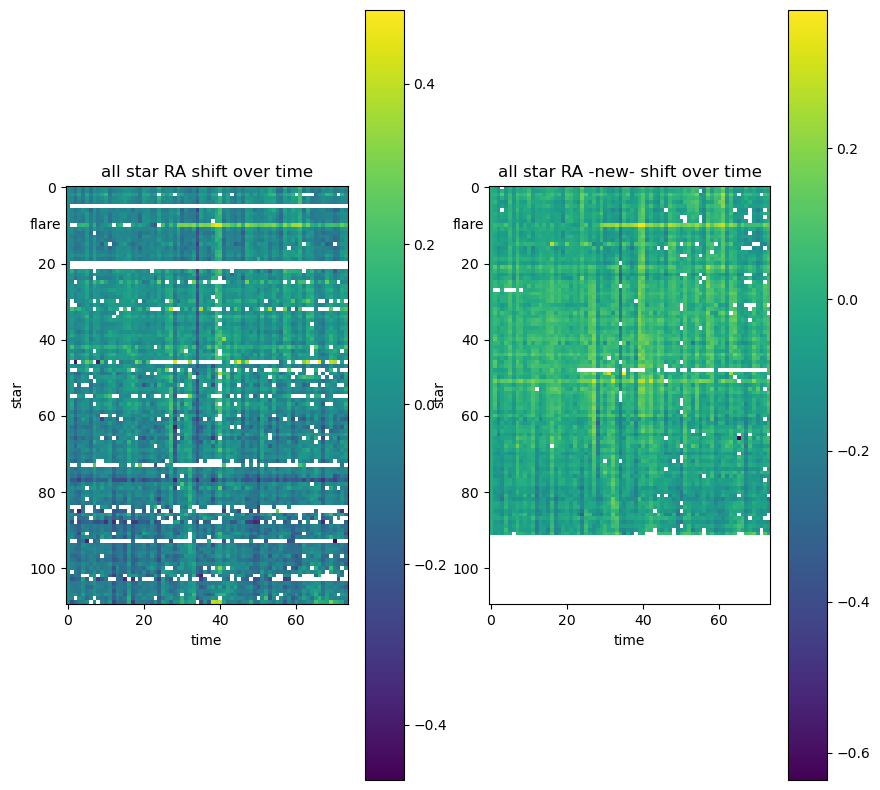

In [432]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(shift_ras["old"].T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star RA shift over time")
axs[0].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(shift_ras["new"].T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")

plt.colorbar(cb);
axs[1].set_title("all star RA -new- shift over time");

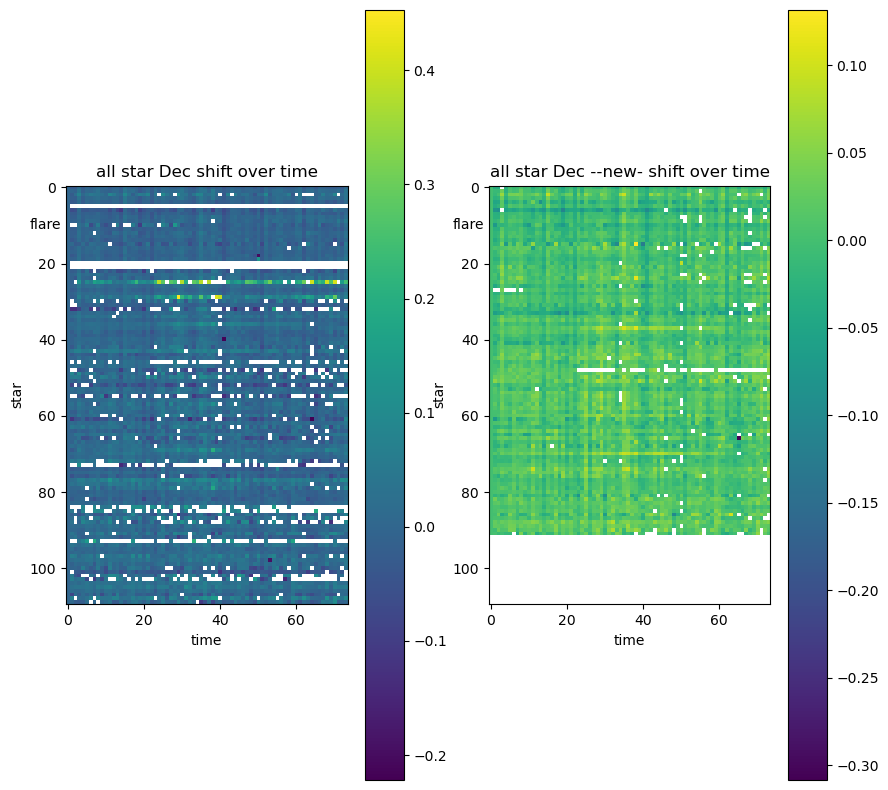

In [433]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
cb = axs[0].imshow(shift_decs["old"].T)
axs[0].set_xlabel("time")
axs[0].set_ylabel("star")
axs[0].set_title("all star Dec shift over time")
axs[0].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")
plt.colorbar(cb)
cb = axs[1].imshow(shift_decs["new"].T)
axs[1].set_xlabel("time")
axs[1].set_ylabel("star")
axs[1].annotate("flare", (-0.6,11), xytext=(-10, 11), color="k")

plt.colorbar(cb);
axs[1].set_title("all star Dec --new- shift over time");


In [434]:
# FBB new array that does not contain flare star
ras_noflare = {}
decs_noflare = {}
ras_noflare["new"] = np.delete(ras["new"], FLAREINDX, 1)
decs_noflare["new"] = np.delete(decs["new"], FLAREINDX, 1)
ras_noflare["old"] = np.delete(ras["old"], FLAREINDX, 1)
decs_noflare["old"] = np.delete(decs["old"], FLAREINDX, 1)
ras_noflare["old"].shape, decs_noflare["old"].shape, ras_noflare["new"].shape, decs_noflare["new"].shape

((74, 109), (74, 109), (74, 109), (74, 109))

In [435]:
# FBB new array that does not contain flare star
shift_ras_noflare, shift_decs_noflare = {}, {}
shift_ras_noflare["old"] = np.delete(shift_ras["old"], FLAREINDX, 1)
shift_decs_noflare["old"] = np.delete(shift_decs["old"], FLAREINDX, 1)
shift_ras_noflare["new"] = np.delete(shift_ras["new"], FLAREINDX, 1)
shift_decs_noflare["new"] = np.delete(shift_decs["new"], FLAREINDX, 1)
shift_ras_noflare["old"].shape, shift_decs_noflare["old"].shape, shift_ras_noflare["new"].shape, shift_decs_noflare["new"].shape

((74, 109), (74, 109), (74, 109), (74, 109))

In [436]:
# FBB new array that does not contain flare star
raerrs_noflare, decerrs_noflare = {},{}
raerrs_noflare["new"] = np.delete(raerrs["new"], FLAREINDX, 1)
decerrs_noflare["new"] = np.delete(decerrs["new"], FLAREINDX, 1)
raerrs_noflare["old"] = np.delete(raerrs["old"], FLAREINDX, 1)
decerrs_noflare["old"] = np.delete(decerrs["old"], FLAREINDX, 1)
raerrs_noflare["old"].shape, decerrs_noflare["old"].shape, raerrs_noflare["new"].shape, decerrs_noflare["new"].shape

((74, 109), (74, 109), (74, 109), (74, 109))

In [437]:
# FBB new array that does not contain flare star
shift_raerrs_noflare, shift_decerrs_noflare = {},{}
shift_raerrs_noflare["new"] = np.delete(shift_raerrs["new"], FLAREINDX, 1)
shift_decerrs_noflare["new"] = np.delete(shift_decerrs["new"], FLAREINDX, 1)
shift_raerrs_noflare["old"] = np.delete(shift_raerrs["old"], FLAREINDX, 1)
shift_decerrs_noflare["old"] = np.delete(shift_decerrs["old"], FLAREINDX, 1)
shift_raerrs_noflare["old"].shape, shift_decerrs_noflare["old"].shape, shift_raerrs_noflare["new"].shape, shift_decerrs_noflare["new"].shape

((74, 109), (74, 109), (74, 109), (74, 109))

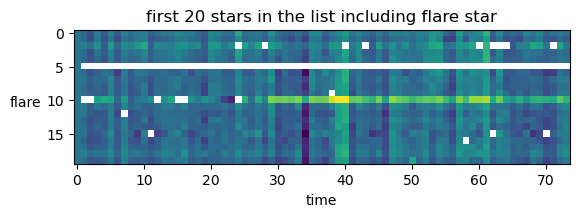

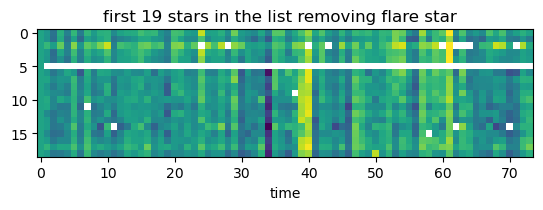

In [438]:
#making sure I removed the flare star: it shows up obviously with a change near epoch 30
plt.imshow(shift_ras["old"][:, :20].T)
plt.xlabel("time")
plt.title("first 20 stars in the list including flare star")
plt.annotate("flare", (1,11), xytext=(-10, 11), color="k")

plt.show()
plt.imshow(shift_ras_noflare["old"][:, :19].T)
plt.title("first 19 stars in the list removing flare star  ")
plt.xlabel("time");


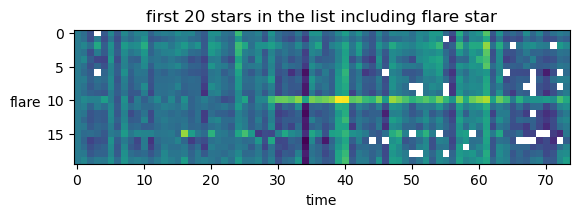

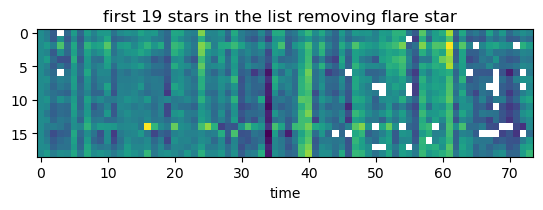

In [439]:
#making sure I removed the flare star: it shows up obviously with a change near epoch 30
plt.imshow(shift_ras["new"][:, :20].T)
plt.xlabel("time")
plt.title("first 20 stars in the list including flare star")
plt.annotate("flare", (1,11), xytext=(-10, 11), color="k")

plt.show()
plt.imshow(shift_ras_noflare["new"][:, :19].T)
plt.title("first 19 stars in the list removing flare star  ")
plt.xlabel("time");


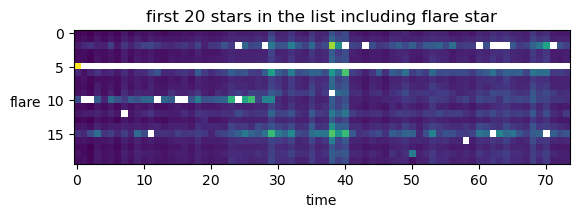

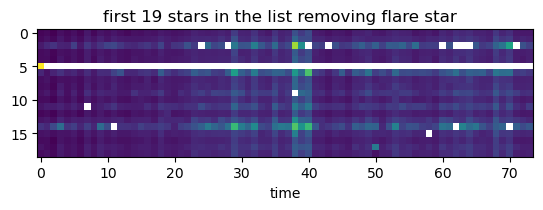

In [440]:
#making sure I removed the flare star: it shows up obviously with a change near epoch 30
plt.imshow(shift_raerrs["old"][:, :20].T)
plt.xlabel("time")
plt.title("first 20 stars in the list including flare star")
plt.annotate("flare", (1,11), xytext=(-10, 11), color="k")

plt.show()
plt.imshow(shift_raerrs_noflare["old"][:, :19].T)
plt.title("first 19 stars in the list removing flare star  ")
plt.xlabel("time");

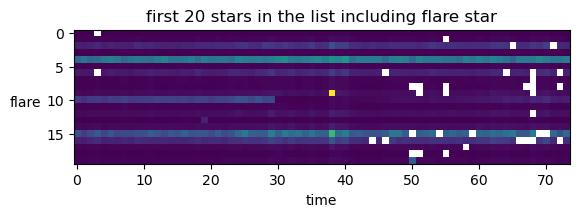

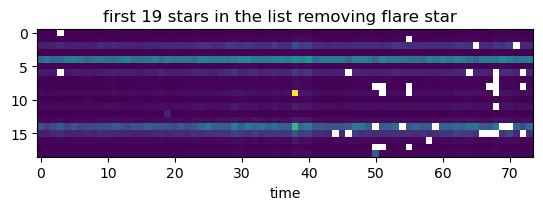

In [441]:
#making sure I removed the flare star: it shows up obviously with a change near epoch 30
plt.imshow(shift_raerrs["new"][:, :20].T)
plt.xlabel("time")
plt.title("first 20 stars in the list including flare star")
plt.annotate("flare", (1,11), xytext=(-10, 11), color="k")

plt.show()
plt.imshow(shift_raerrs_noflare["new"][:, :19].T)
plt.title("first 19 stars in the list removing flare star  ")
plt.xlabel("time");

In [442]:
# FBB make an array for RA of flare and dec of flare only
shift_ras_flare = {} 
shift_decs_flare = {}
shift_ras_flare["old"] = shift_ras["old"][:,FLAREINDX] 
shift_decs_flare["old"] = shift_decs["old"][:,FLAREINDX]
shift_ras_flare["new"] = shift_ras["new"][:,FLAREINDX] 
shift_decs_flare["new"] = shift_decs["new"][:,FLAREINDX]
# FBB make an array for RA of flare and dec of flare only
shift_raerrs_flare = {}
shift_decerrs_flare = {}
shift_raerrs_flare["old"] = shift_raerrs["old"][:,FLAREINDX]
shift_decerrs_flare["old"] = shift_decerrs["old"][:,FLAREINDX]
shift_raerrs_flare["new"] = shift_raerrs["new"][:,FLAREINDX]
shift_decerrs_flare["new"] = shift_decerrs["new"][:,FLAREINDX]
shift_ras_flare["old"].shape, shift_decs_flare["old"].shape, shift_raerrs_flare["new"].shape, shift_decerrs_flare["new"].shape

((74,), (74,), (74,), (74,))

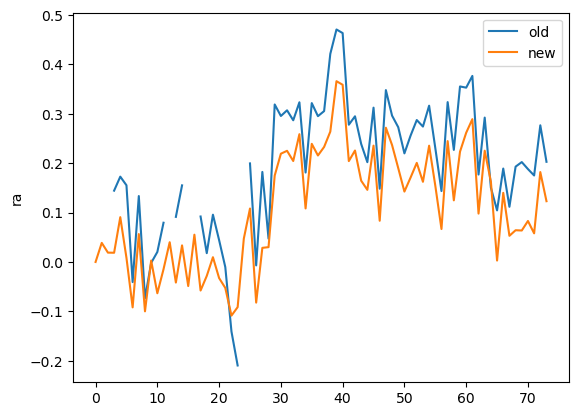

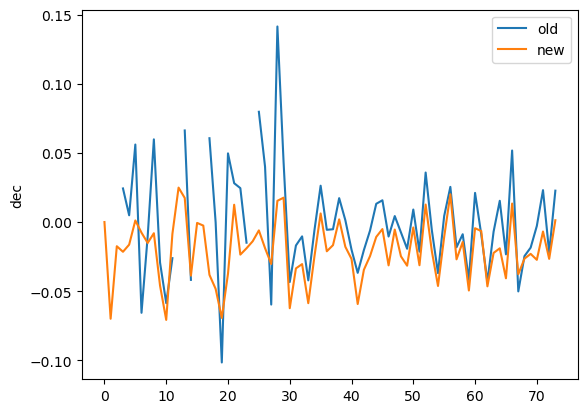

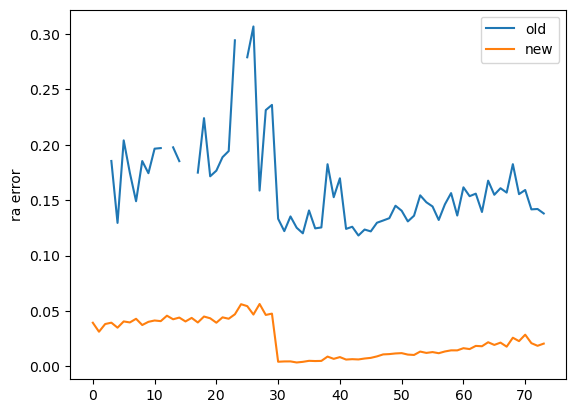

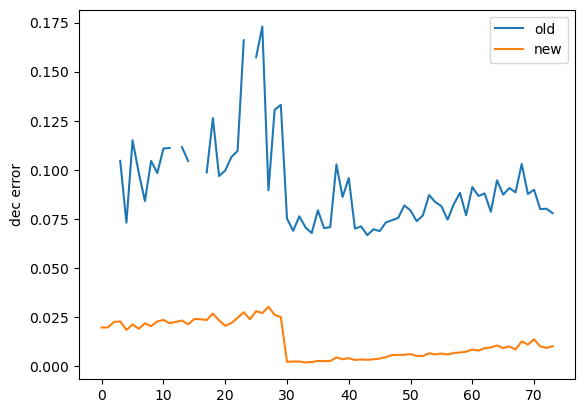

In [443]:
plt.plot(shift_ras_flare["old"], label="old")
plt.plot(shift_ras_flare["new"], label="new")
plt.ylabel("ra")
plt.legend()
plt.show()
plt.plot(shift_decs_flare["old"], label="old")
plt.plot(shift_decs_flare["new"], label="new")
plt.ylabel("dec")
plt.legend()
plt.show()
plt.plot(shift_raerrs_flare["old"], label="old")
plt.plot(shift_raerrs_flare["new"], label="new")
plt.ylabel("ra error")
plt.legend()
plt.show()
plt.plot(shift_decerrs_flare["old"], label="old")
plt.plot(shift_decerrs_flare["new"], label="new")
plt.ylabel("dec error")
plt.legend()
plt.show()

In [444]:
if SAVE:
    np.save('Outdata/ras.npy', ras["new"])
    np.save('Outdata/decs.npy', decs["new"])

    np.save('Outdata/ra_change.npy', shift_ras["new"])
    np.save('Outdata/dec_chane.npy', shift_decs["new"])

In [445]:
if SAVE:
    np.save('Outdata/raerrs.npy', raerrs["new"])
    np.save('Outdata/decerrs.npy', decerrs["new"])

In [446]:
#only not nan values
select_old = np.isnan(shift_ras_noflare["old"]).sum(axis=0)==0
select_new = np.isnan(shift_ras_noflare["new"]).sum(axis=0)==0
shift_ras_noflare["new"][:, select_new].shape, shift_ras_noflare["old"][:, select_old].shape

((74, 34), (74, 49))

In [447]:
# FBB use shiftarray instead of subtracting first epoch again
dra_mean, ddec_mean, dra_mean_onlyfullydetected, ddec_mean_onlyfullydetected = {}, {}, {}, {}

dra_mean["new"] = np.nanmean(shift_ras_noflare["new"], axis=1) 
ddec_mean["new"] = np.nanmean(shift_decs_noflare["new"], axis=1) 
dra_mean_onlyfullydetected["new"] = np.mean(shift_ras_noflare["new"][:, select_new], axis=1) #only stars available in all obs
ddec_mean_onlyfullydetected["new"] = np.mean(shift_ras_noflare["new"][:, select_new], axis=1) #only stars available in all obs
dra_mean["old"] = np.nanmean(shift_ras_noflare["old"], axis=1) 
ddec_mean["old"] = np.nanmean(shift_decs_noflare["old"], axis=1) 
dra_mean_onlyfullydetected["old"] = np.mean(shift_ras_noflare["old"][:, select_old], axis=1) #only stars available in all obs
ddec_mean_onlyfullydetected["old"] = np.mean(shift_ras_noflare["old"][:, select_old], axis=1) #only stars available in all obs

dra_std, ddec_std, dra_std_onlyfullydetected, ddec_std_onlyfullydetected = {}, {}, {}, {}

dra_std["new"] = np.nanstd(shift_ras_noflare["new"], axis=1) 
ddec_std["new"] = np.nanstd(shift_decs_noflare["new"], axis=1) 
dra_std_onlyfullydetected["new"] = np.std(shift_ras_noflare["new"][:, select_new], axis=1) #only stars available in all obs
ddec_std_onlyfullydetected["new"] = np.std(shift_decs_noflare["new"][:, select_new], axis=1)  #only stars available in all obs
dra_std["old"] = np.nanstd(shift_ras_noflare["old"], axis=1) 
ddec_std["old"] = np.nanstd(shift_decs_noflare["old"], axis=1) 
dra_std_onlyfullydetected["old"] = np.std(shift_ras_noflare["old"][:, select_old], axis=1) #only stars available in all obs
ddec_std_onlyfullydetected["old"] = np.std(shift_decs_noflare["old"][:, select_old], axis=1)  #only stars available in all obs
                    

In [448]:
#standard deviation of each star error overall
raerr_std, decerr_std = {}, {}
raerr_std["new"] = np.nanstd(raerrs["new"], axis=1) 
decerr_std["new"] = np.nanstd(decerrs["new"], axis=1) 
raerr_std["old"] = np.nanstd(raerrs["old"], axis=1) 
decerr_std["old"] = np.nanstd(decerrs["old"], axis=1) 

#error as standard deviation of the segment for the flare star
raunc_before, raunc_after, decunc_before, decunc_after, raunc, decunc = {},{},{},{},{},{}
raunc_before["new"] = np.nanstd(shift_ras_flare["new"][:20])
raunc_after["new"] = np.nanstd(shift_ras_flare["new"][30:])
decunc_before["new"] = np.nanstd(shift_ras_flare["new"][:20])
decunc_after["new"]  = np.nanstd(shift_ras_flare["new"][30:])
#new uncertainty arrays for flare star
raunc["new"] = np.array([raunc_before["new"]]*23 + [raunc_after["new"]]*(len(shift_ras_flare["new"])-23))
decunc["new"] = np.array([decunc_before["new"]]*23 + [decunc_after["new"]]*(len(shift_ras_flare["new"])-23))

raunc_before["old"] = np.nanstd(shift_ras_flare["old"][:20])
raunc_after["old"] = np.nanstd(shift_ras_flare["old"][30:])
decunc_before["old"] = np.nanstd(shift_ras_flare["old"][:20])
decunc_after["old"]  = np.nanstd(shift_ras_flare["old"][30:])
#new uncertainty arrays for flare star
raunc["old"] = np.array([raunc_before["old"]]*23 + [raunc_after["old"]]*(len(shift_ras_flare["old"])-23))
decunc["old"] = np.array([decunc_before["old"]]*23 + [decunc_after["old"]]*(len(shift_ras_flare["old"])-23))

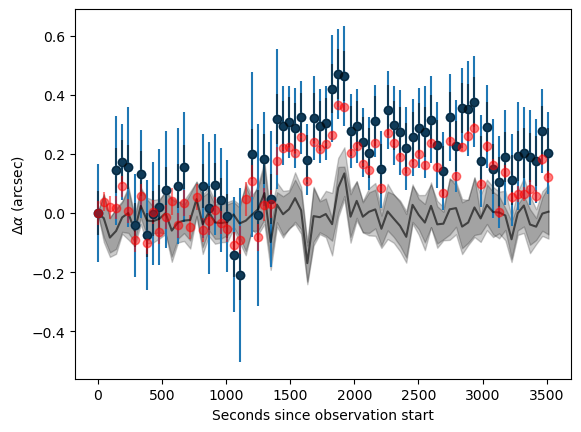

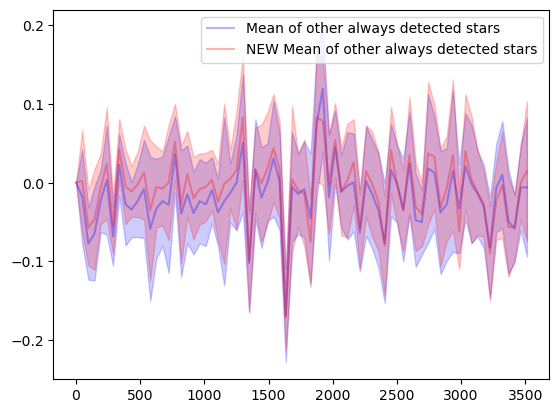

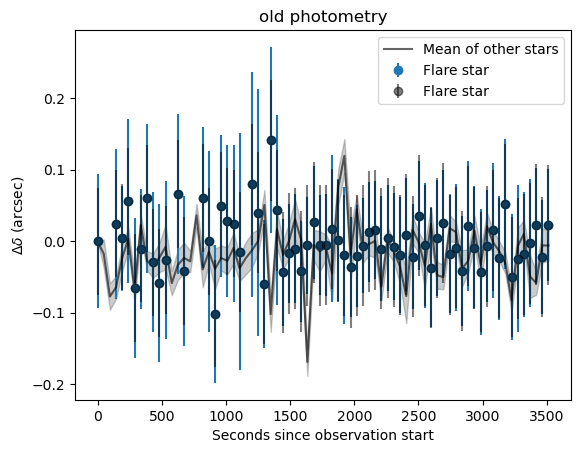

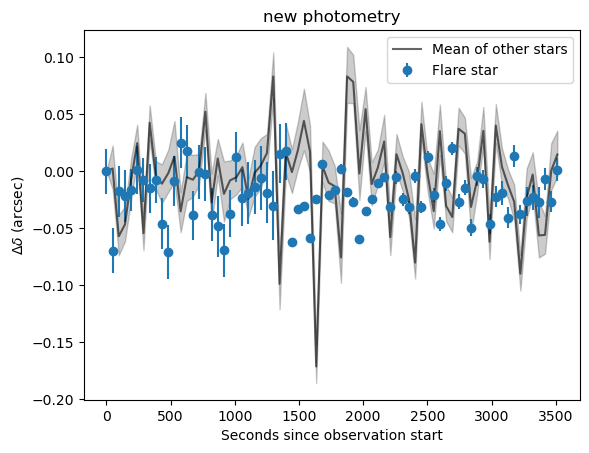

In [449]:
plt.errorbar(dt_sec, shift_ras_flare["old"][t_index], 
             yerr = shift_raerrs_flare["old"][t_index], marker='o', ls='None', label='Flare star w errors')
plt.errorbar(dt_sec, shift_ras_flare["old"][t_index], 
             yerr = raunc["old"][t_index], color="k", alpha=0.5,
             marker='o', ls='None', label='Flare star w stdev')
plt.errorbar(dt_sec, shift_ras_flare["new"][t_index], 
             yerr = shift_raerrs_flare["new"][t_index], color="r", alpha=0.5,
             marker='o', ls='None', label='Flare star w stdev')
plt.plot(dt_sec, dra_mean["old"][t_index], c='k', alpha=0.6, label='Mean of all other stars')
plt.fill_between(dt_sec, dra_mean["old"][t_index] + dra_std["old"][t_index], 
                 dra_mean["old"][t_index] - dra_std["old"][t_index], color='k', alpha=0.2)
plt.fill_between(dt_sec, dra_mean["new"][t_index] + dra_std["new"][t_index], 
                 dra_mean["old"][t_index] - dra_std["new"][t_index], color='k', alpha=0.2)
plt.ylabel(r'$\Delta\alpha$ (arcsec)')
plt.xlabel('Seconds since observation start')
plt.show()


plt.plot(dt_sec, dra_mean_onlyfullydetected["old"][t_index], c='b', alpha=0.3, label='Mean of other always detected stars')
plt.fill_between(dt_sec, dra_mean_onlyfullydetected["old"][t_index] + dra_std_onlyfullydetected["old"][t_index], 
                 dra_mean_onlyfullydetected["old"][t_index] - dra_std_onlyfullydetected["old"][t_index], color='b', 
                 alpha=0.2)
plt.plot(dt_sec, dra_mean_onlyfullydetected["new"][t_index], c='r', alpha=0.3, label='NEW Mean of other always detected stars')
plt.fill_between(dt_sec, dra_mean_onlyfullydetected["new"][t_index] + dra_std_onlyfullydetected["new"][t_index], 
                 dra_mean_onlyfullydetected["new"][t_index] - dra_std_onlyfullydetected["new"][t_index], color='r', 
                 alpha=0.2)
plt.legend()
plt.show()


plt.errorbar(dt_sec, shift_decs_flare["old"][t_index], 
             yerr = shift_decerrs_flare["old"][t_index], marker='o', ls='None', label='Flare star')
plt.errorbar(dt_sec, shift_decs_flare["old"][t_index], 
             yerr = decunc["old"][t_index], color='k', alpha=0.5,marker='o', ls='None', label='Flare star')
plt.plot(dt_sec, ddec_mean_onlyfullydetected["old"][t_index], c='k', alpha=0.6, label='Mean of other stars')
plt.fill_between(dt_sec, ddec_mean_onlyfullydetected["old"][t_index] + ddec_std_onlyfullydetected["old"][t_index], 
                 ddec_mean_onlyfullydetected["old"][t_index] - ddec_std_onlyfullydetected["old"][t_index], color='k', alpha=0.2)
plt.xlabel('Seconds since observation start')
plt.ylabel(r'$\Delta\delta$ (arcsec)')
plt.title("old photometry")
plt.legend()
plt.show()


plt.errorbar(dt_sec, shift_decs_flare["new"][t_index], 
             yerr = shift_decerrs_flare["new"][t_index], marker='o', ls='None', label='Flare star')
plt.plot(dt_sec, ddec_mean_onlyfullydetected["new"][t_index], c='k', alpha=0.6, label='Mean of other stars')
plt.fill_between(dt_sec, ddec_mean_onlyfullydetected["new"][t_index] + ddec_std_onlyfullydetected["old"][t_index], 
                 ddec_mean_onlyfullydetected["new"][t_index] - ddec_std_onlyfullydetected["new"][t_index], color='k', alpha=0.2)
plt.xlabel('Seconds since observation start')
plt.ylabel(r'$\Delta\delta$ (arcsec)')
plt.title("new photometry")

plt.legend()
plt.show()


In [450]:
len(shift_raerrs_flare), len(dt_sec)

(2, 74)

Text(0.5, 1.0, 'old')

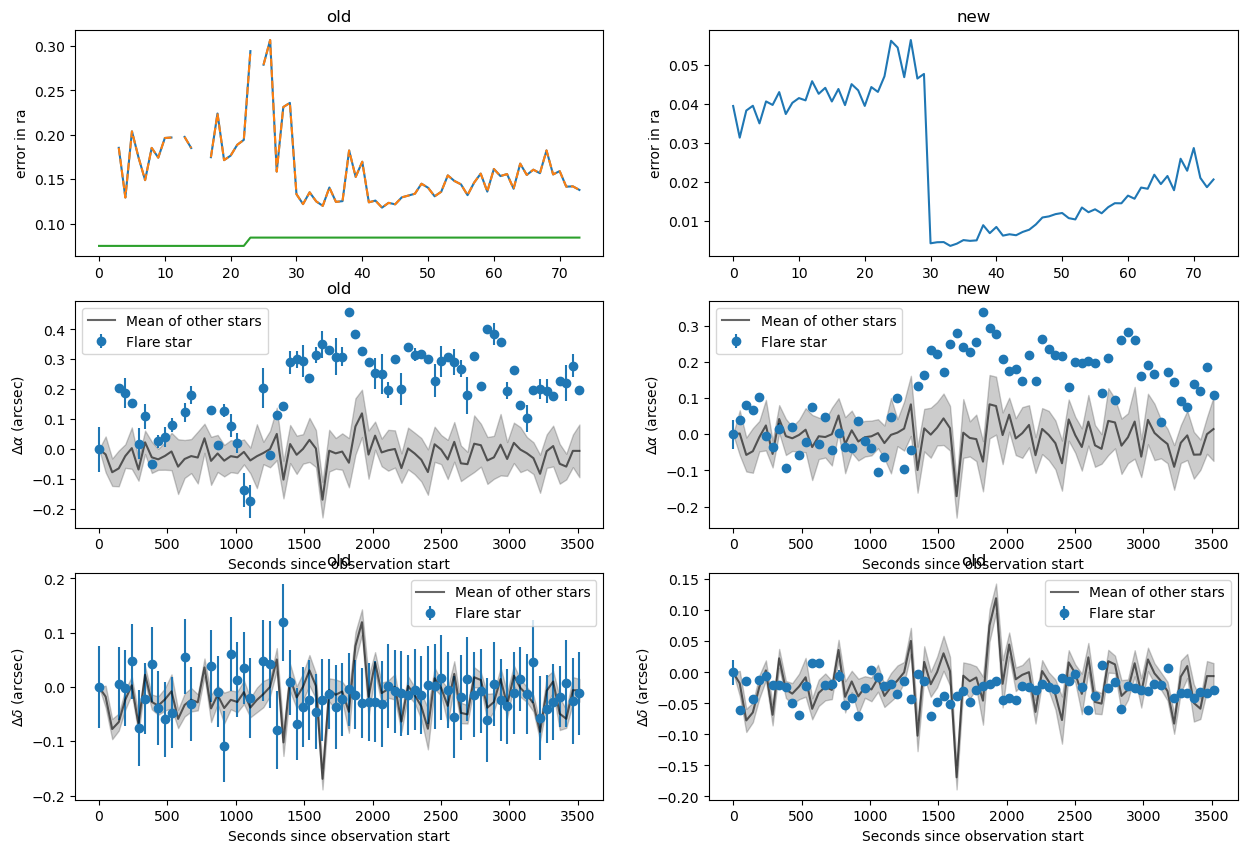

In [451]:
#using only stars with complete coverage at all epochs
err = {}
fig, axs = plt.subplots(3,2, figsize=(15,10))
axs = axs.ravel()
err["old"] = shift_raerrs_flare["old"], shift_decerrs_flare["old"]
axs[0].plot(raerrs["old"][:,FLAREINDX] * D2ARCSEC)
axs[0].plot(err["old"][0], '--')
err["old"] = raunc["old"], decunc["old"]
axs[0].plot(err["old"][0])
axs[0].set_ylabel("error in ra")
axs[0].set_title("old")


axs[2].errorbar(dt_sec, shift_ras_flare["old"][t_index] - dra_mean["old"][t_index],
             yerr = np.sqrt(err["old"][0][t_index]**2 
                            - dra_std["old"][t_index]**2) , marker='o', ls='None', label='Flare star')
axs[2].plot(dt_sec, dra_mean_onlyfullydetected["old"][t_index], c='k', alpha=0.6, label='Mean of other stars')
axs[2].fill_between(dt_sec, dra_mean_onlyfullydetected["old"][t_index] + dra_std_onlyfullydetected["old"][t_index], 
                 dra_mean_onlyfullydetected["old"][t_index] - dra_std_onlyfullydetected["old"][t_index], color='k', alpha=0.2)
axs[2].set_ylabel(r'$\Delta\alpha$ (arcsec)')
axs[2].set_xlabel('Seconds since observation start')
axs[2].legend()
axs[2].set_title("old")
#plt.show()

axs[4].errorbar(dt_sec, shift_decs_flare["old"][t_index] - ddec_mean["old"][t_index],
             yerr = np.sqrt(err["old"][1][t_index]**2 - ddec_std["old"][t_index] **2), marker='o', ls='None', label='Flare star')
axs[4].plot(dt_sec, ddec_mean_onlyfullydetected["old"][t_index], c='k', alpha=0.6, label='Mean of other stars')
axs[4].fill_between(dt_sec, ddec_mean_onlyfullydetected["old"][t_index] + ddec_std_onlyfullydetected["old"][t_index], 
                 ddec_mean_onlyfullydetected["old"][t_index] - ddec_std_onlyfullydetected["old"][t_index], color='k', alpha=0.2)
axs[4].set_xlabel('Seconds since observation start')
axs[4].set_ylabel(r'$\Delta\delta$ (arcsec)')
axs[4].legend()
axs[4].set_title("old")

err["new"] = shift_raerrs_flare["new"], shift_decerrs_flare["new"]

axs[1].plot(raerrs["new"][:,FLAREINDX] * D2ARCSEC)
axs[1].set_ylabel("error in ra")
axs[1].set_title("new")


axs[3].errorbar(dt_sec, shift_ras_flare["new"][t_index] - dra_mean["new"][t_index],
             yerr = np.sqrt(err["new"][0][t_index]**2 
                            - dra_std["new"][t_index]**2) , marker='o', ls='None', label='Flare star')
axs[3].plot(dt_sec, dra_mean_onlyfullydetected["new"][t_index], c='k', alpha=0.6, label='Mean of other stars')
axs[3].fill_between(dt_sec, dra_mean_onlyfullydetected["new"][t_index] + dra_std_onlyfullydetected["new"][t_index], 
                 dra_mean_onlyfullydetected["new"][t_index] - dra_std_onlyfullydetected["old"][t_index], color='k', alpha=0.2)
axs[3].set_ylabel(r'$\Delta\alpha$ (arcsec)')
axs[3].set_xlabel('Seconds since observation start')
axs[3].legend()
axs[3].set_title("new")
#plt.show()

axs[5].errorbar(dt_sec, shift_decs_flare["new"][t_index] - ddec_mean["new"][t_index],
             yerr = np.sqrt(err["new"][1][t_index]**2 - ddec_std["old"][t_index] **2), marker='o', ls='None', label='Flare star')
axs[5].plot(dt_sec, ddec_mean_onlyfullydetected["old"][t_index], c='k', alpha=0.6, label='Mean of other stars')
axs[5].fill_between(dt_sec, ddec_mean_onlyfullydetected["old"][t_index] + ddec_std_onlyfullydetected["old"][t_index], 
                 ddec_mean_onlyfullydetected["old"][t_index] - ddec_std_onlyfullydetected["old"][t_index], color='k', alpha=0.2)
axs[5].set_xlabel('Seconds since observation start')
axs[5].set_ylabel(r'$\Delta\delta$ (arcsec)')
axs[5].legend()
axs[5].set_title("old")


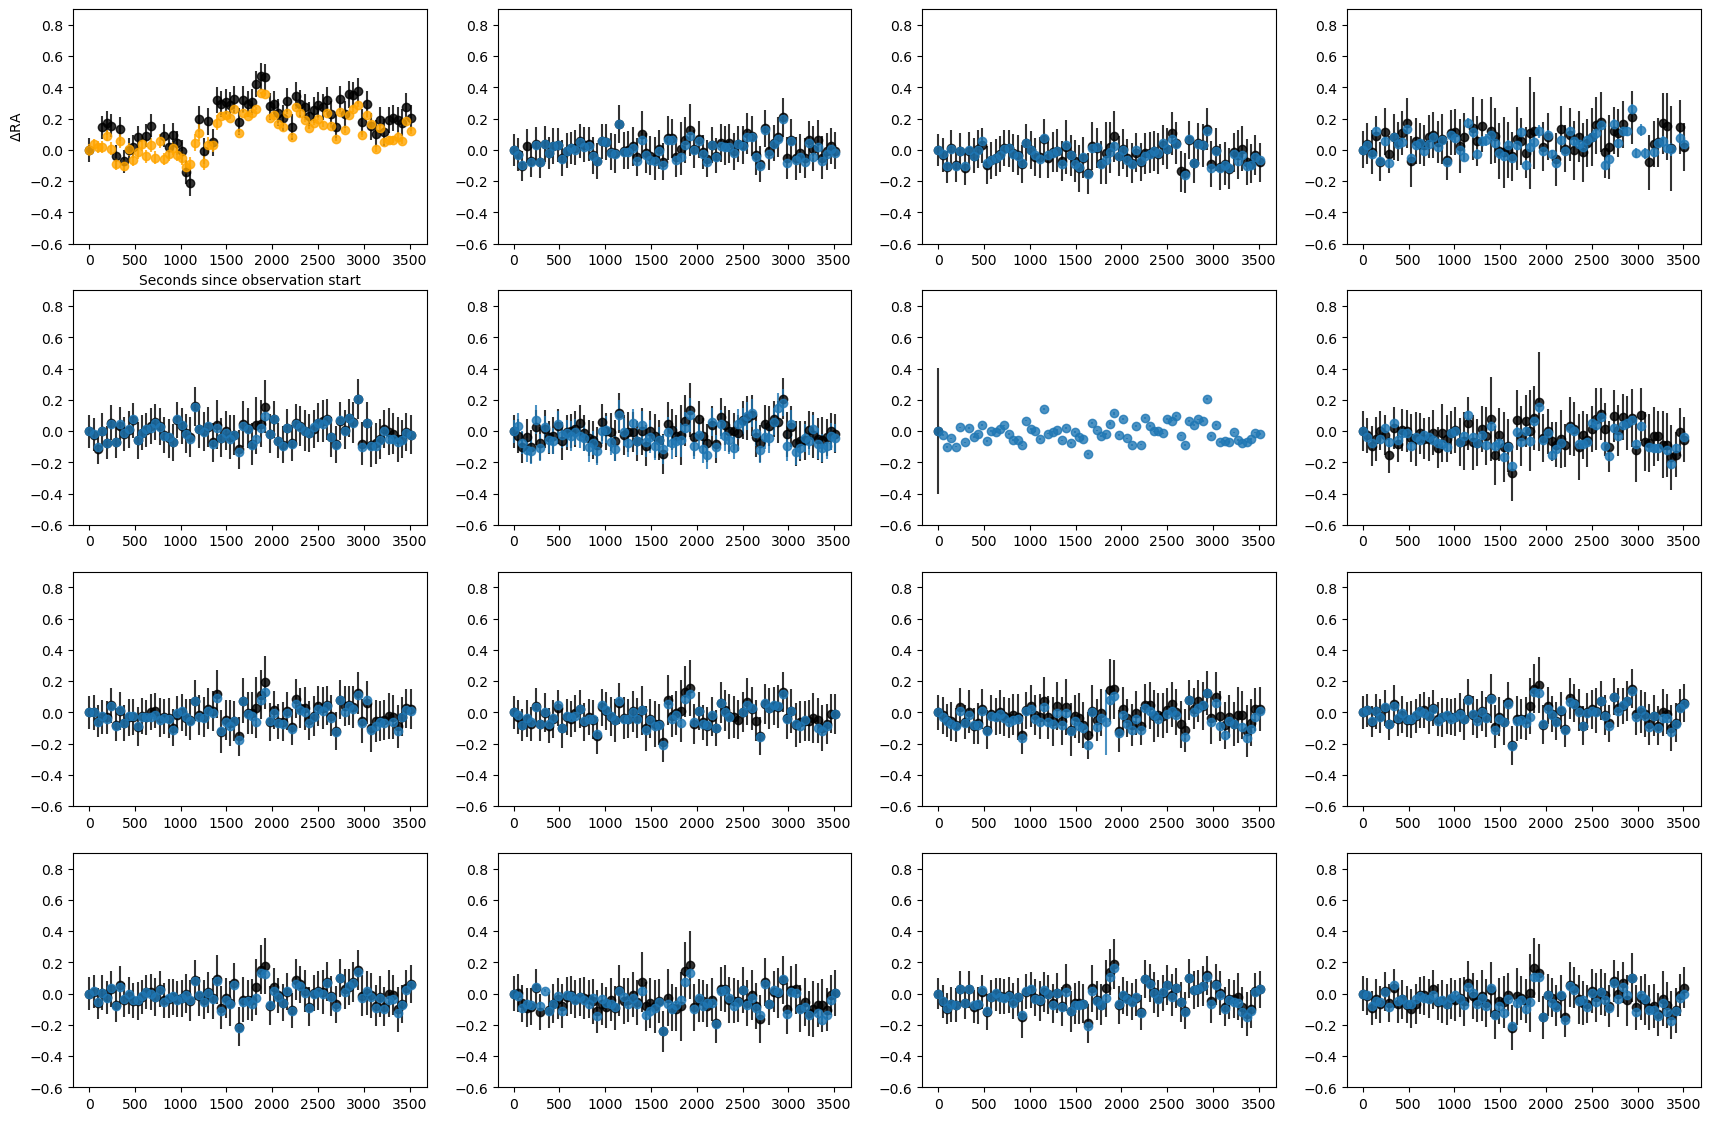

In [460]:
# FBB use shiftarrays which are already relative position and already in arcsec
fig, ax = plt.subplots(4,4, figsize=(21,14))

ax[0][0].errorbar(dt_sec, shift_ras["old"][:,flr_id-1][t_index], yerr=err["old"][0][t_index], color='k', ls='None', marker='o', alpha=0.8)
ax[0][0].errorbar(dt_sec, shift_ras["new"][:,flr_id-1][t_index], yerr=err["new"][0][t_index], color='orange', ls='None', marker='o', alpha=0.8)

ax[0][0].set_ylim(-0.6,0.9)
ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel(r'$\Delta$RA')

for i, subax in enumerate(ax.flatten()[1:]):
    if i == flr_id-1:
        i += 1
    subax.errorbar(dt_sec, shift_ras["old"][:,i][t_index], yerr=shift_raerrs["old"][:,i][t_index], ls='None', marker='o', color='k', alpha=0.8)
    subax.errorbar(dt_sec, shift_ras["new"][:,i][t_index], yerr=shift_raerrs["new"][:,i][t_index], ls='None', marker='o', alpha=0.8)
    subax.set_ylim(-0.6,0.9)

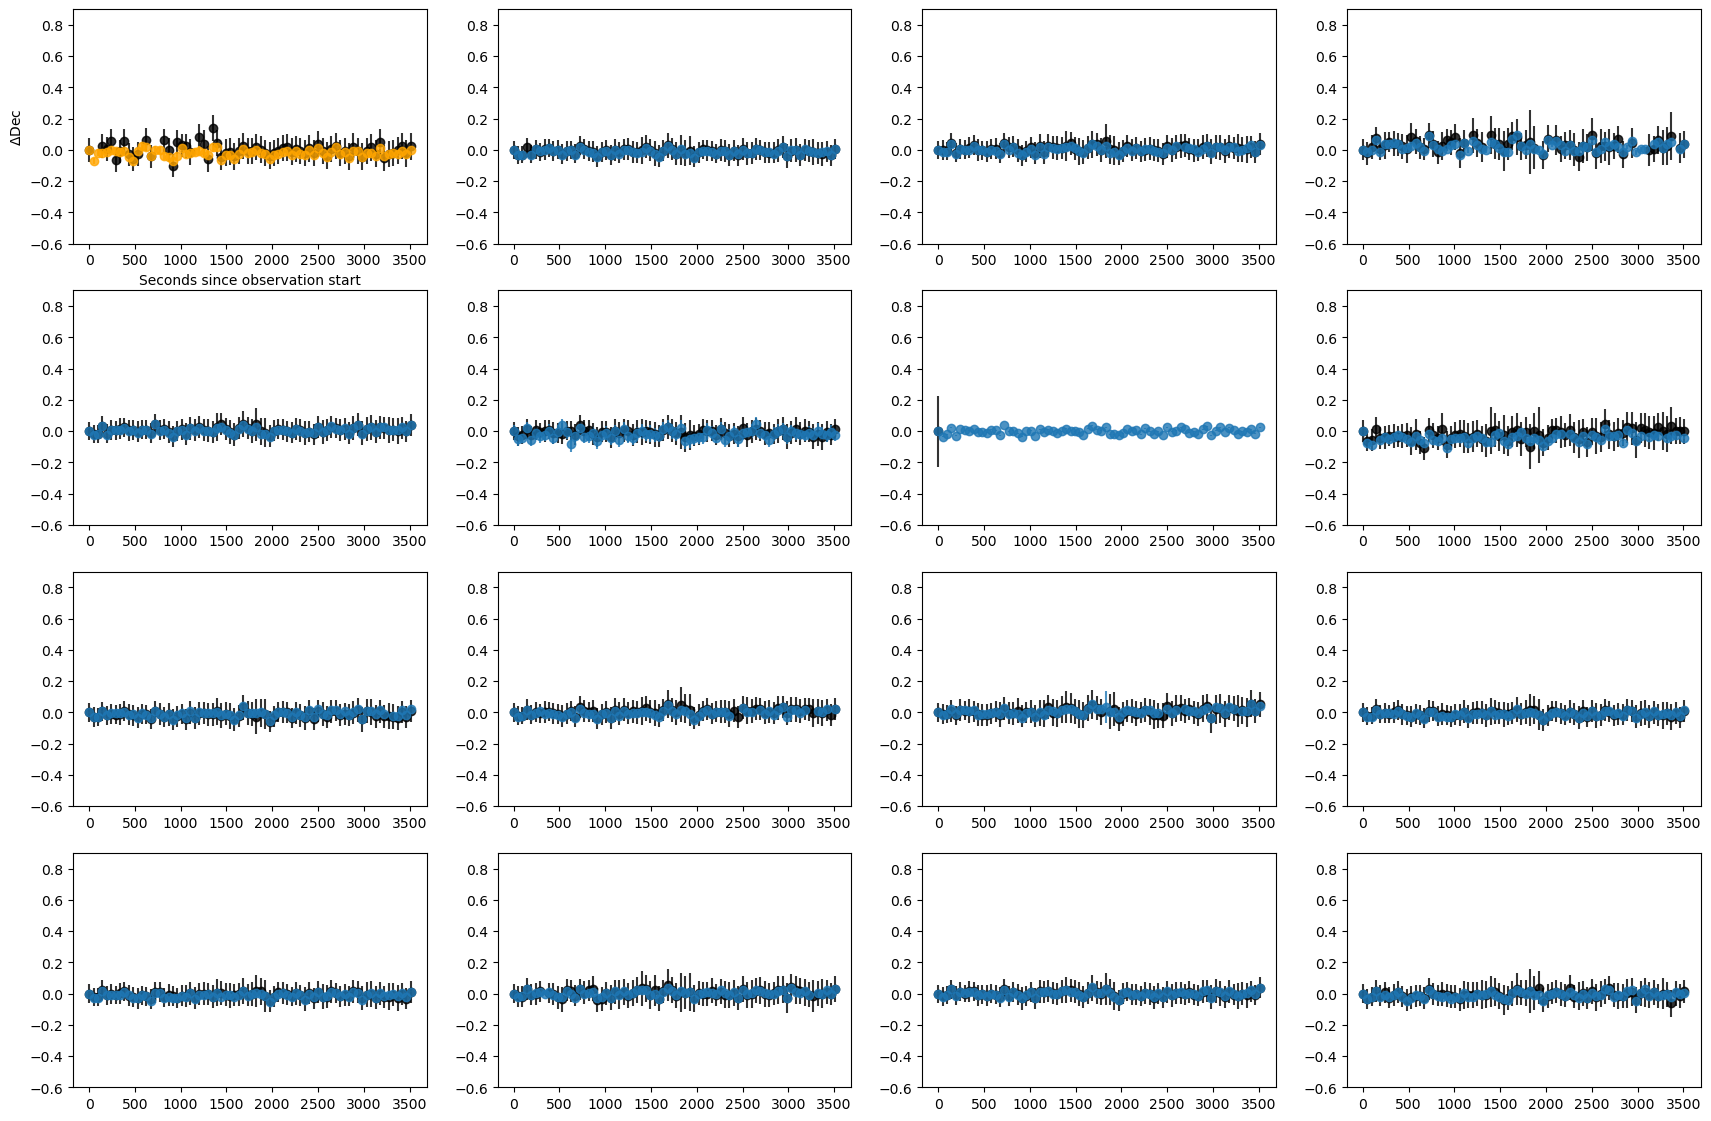

In [461]:
# FBB use shiftarrays which are already relative position and already in arcsec
fig, ax = plt.subplots(4,4, figsize=(21,14))

ax[0][0].errorbar(dt_sec, shift_decs["old"][:,flr_id-1][t_index], yerr=err["old"][1][t_index], color='k', ls='None', marker='o', alpha=0.8)
ax[0][0].errorbar(dt_sec, shift_decs["new"][:,flr_id-1][t_index], yerr=err["new"][1][t_index], color='orange', ls='None', marker='o', alpha=0.8)

ax[0][0].set_ylim(-0.6,0.9)
ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel(r'$\Delta$Dec')

for i, subax in enumerate(ax.flatten()[1:]):
    if i == flr_id-1:
        i += 1
    subax.errorbar(dt_sec, shift_decs["old"][:,i][t_index], yerr=shift_decerrs["old"][:,i][t_index], ls='None', color='k', marker='o', alpha=0.8)
    subax.errorbar(dt_sec, shift_decs["new"][:,i][t_index], yerr=shift_decerrs["new"][:,i][t_index], ls='None', marker='o', alpha=0.8)
    subax.set_ylim(-0.6,0.9)

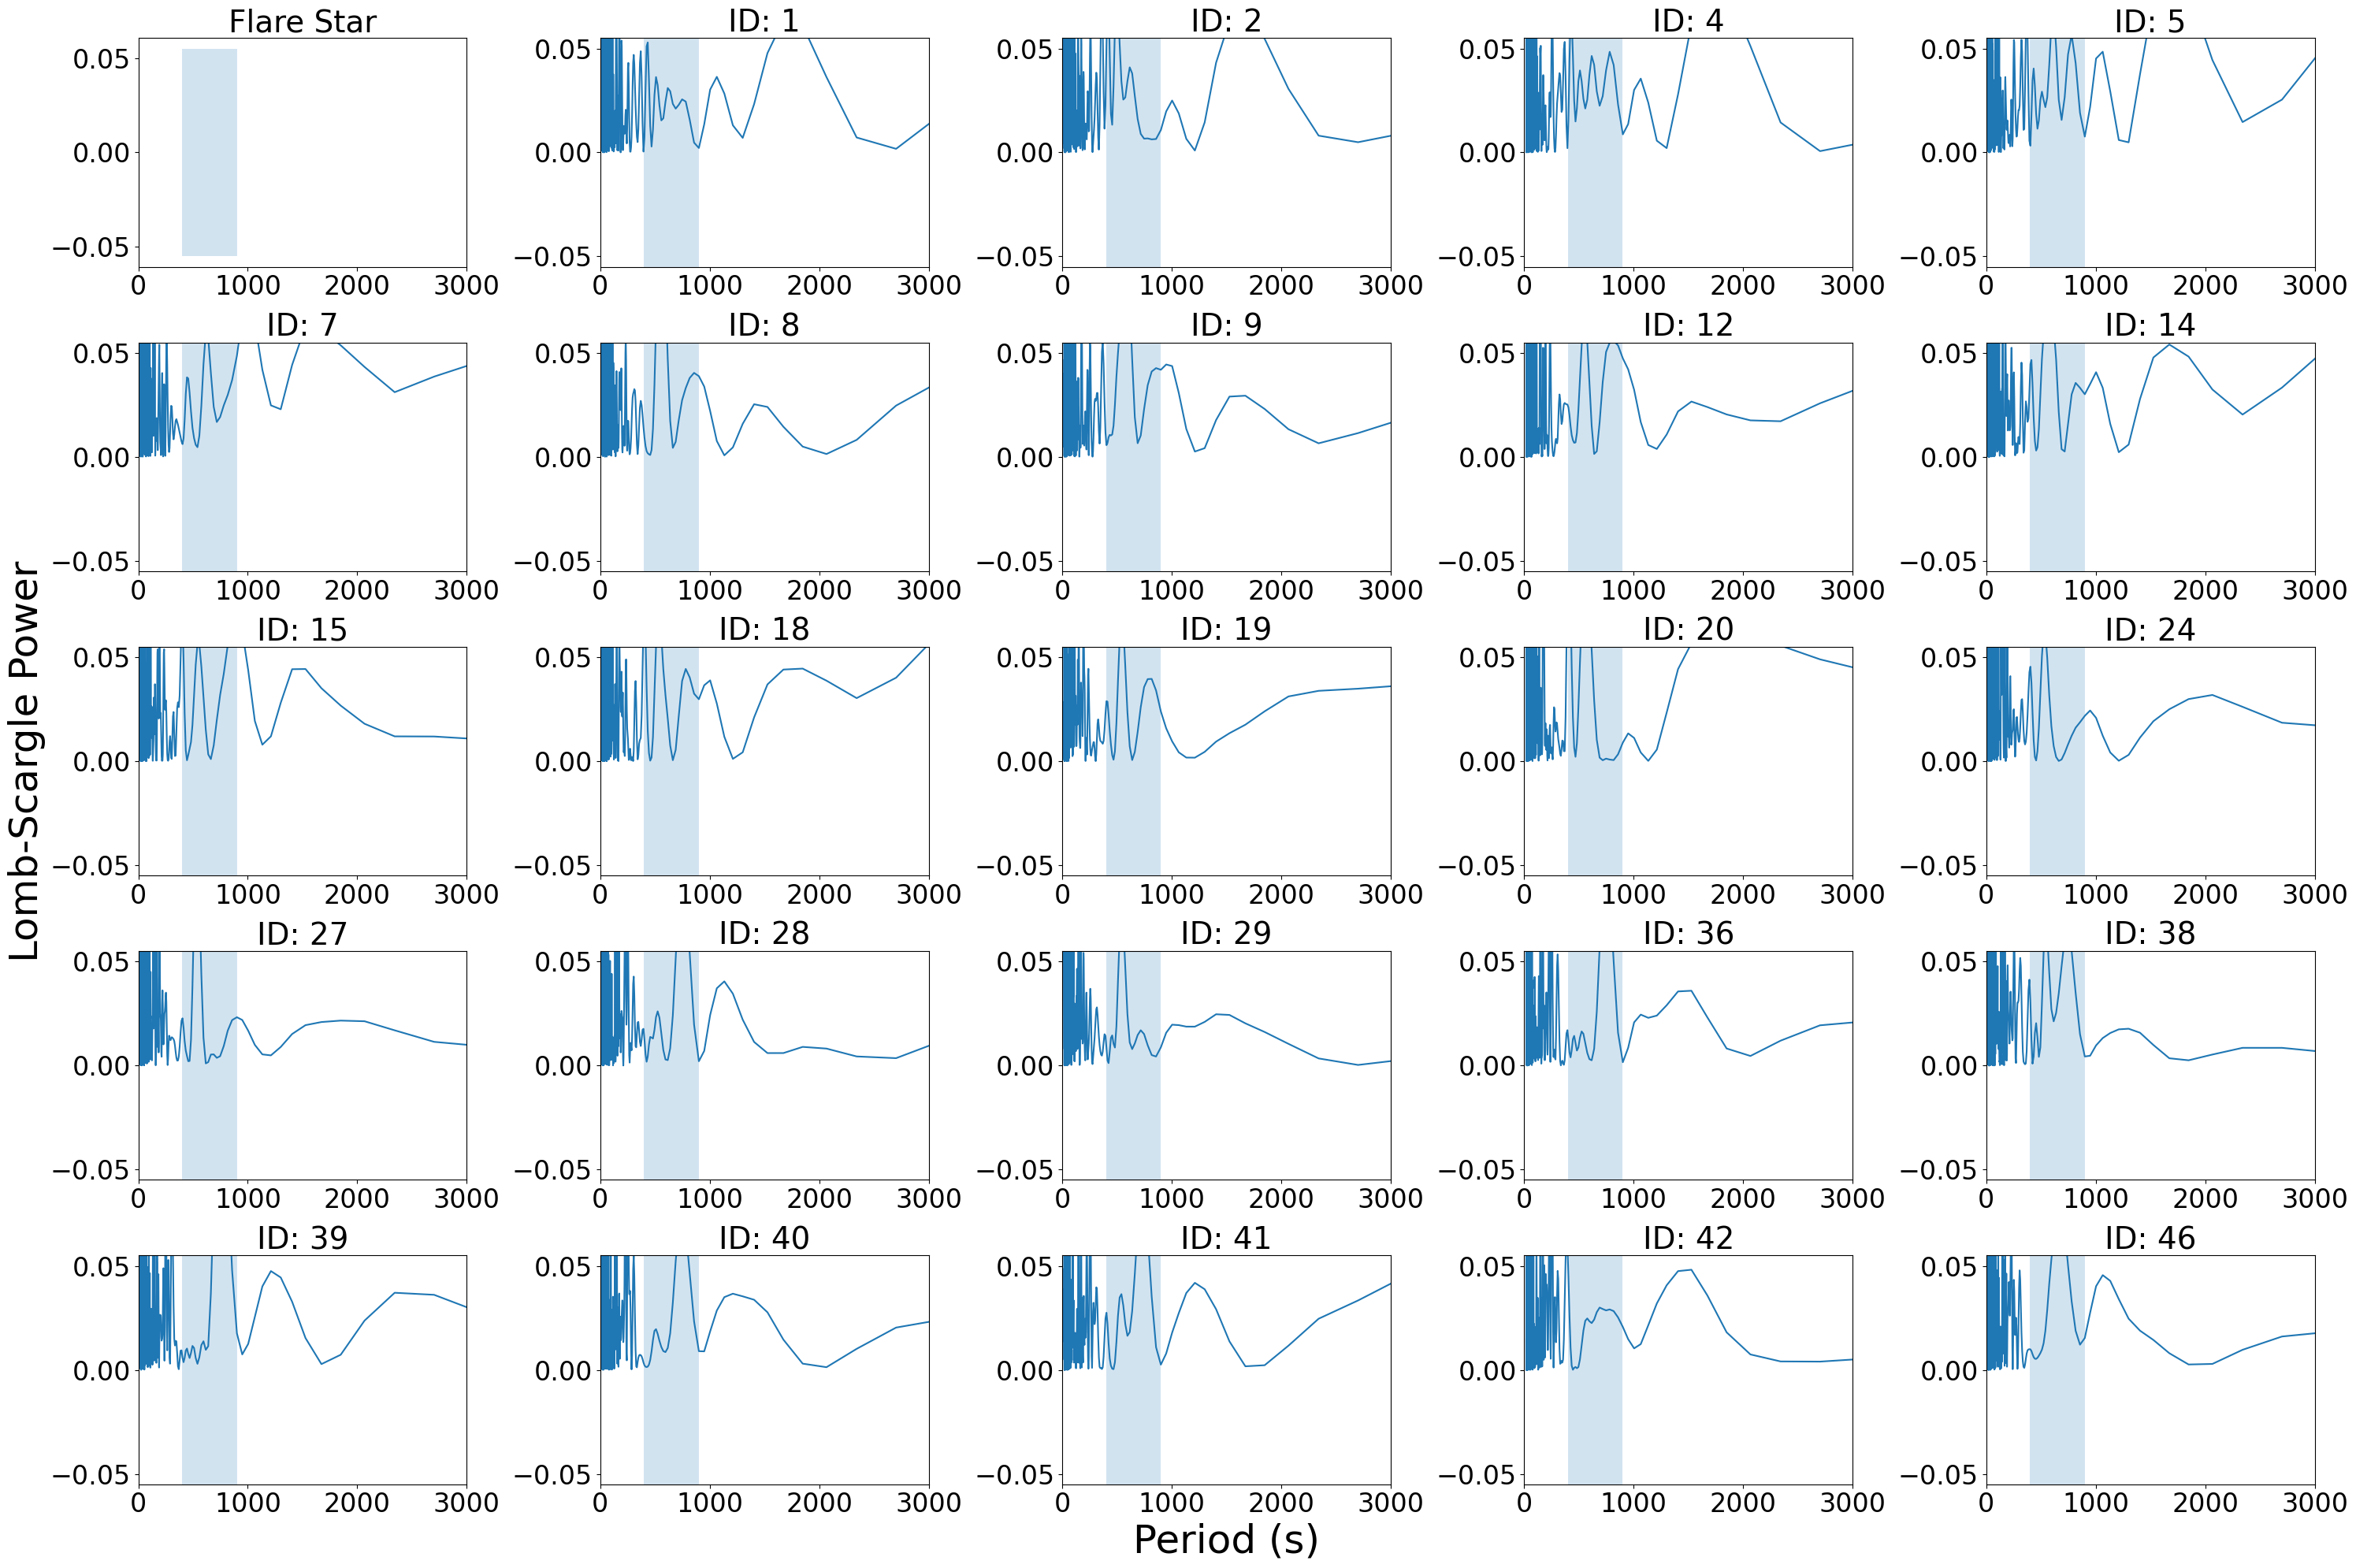

In [462]:
fig, ax = plt.subplots(5,5, figsize=(30,20))

freq, pow = LombScargle(dt_sec, shift_ras["old"][:,flr_id-1][t_index], err["old"][0][t_index]).autopower()

ax.flatten()[0].plot(1/freq,pow, c='orange')
ax.flatten()[0].set_xlim(0,3_000)

c = 0

for i in range(1,len(ax.flatten())):

    freq, pow = LombScargle(dt_sec, shift_ras["old"][:,c][t_index], shift_raerrs["old"][:,c][t_index]).autopower()

    while (np.isnan(pow)).any():
        c += 1
        if c == flr_id - 1:
            c += 1
        freq, pow = LombScargle(dt_sec, shift_ras["old"][:,c][t_index], shift_raerrs["old"][:,c][t_index]).autopower()

    ax.flatten()[i].plot(1/freq, pow)
    ax.flatten()[i].set_xlim(0,3000)
    ax.flatten()[i].set_ylim(ax.flatten()[0].get_ylim())

    if i == 22:
        ax.flatten()[i].set_xlabel('Period (s)', fontsize=36)
    if i == 10:
        ax.flatten()[i].set_ylabel('Lomb-Scargle Power', fontsize=36)

    ax.flatten()[i].set_title('ID: {}'.format(c+1), fontsize=28)
    c += 1

for a in ax.flatten():
    a.tick_params(axis='both', labelsize=24)
    a.fill_betweenx(y = [a.get_ylim()[0], a.get_ylim()[1]], x1=400, x2=900, alpha=0.2)

#ax.flatten()[0].set_ylim(-0.03, 0.7)
ax.flatten()[0].set_title('Flare Star', fontsize=28)

fig.tight_layout()

plt.savefig('Figures/dparffts.png', dpi=300, bbox_inches='tight')

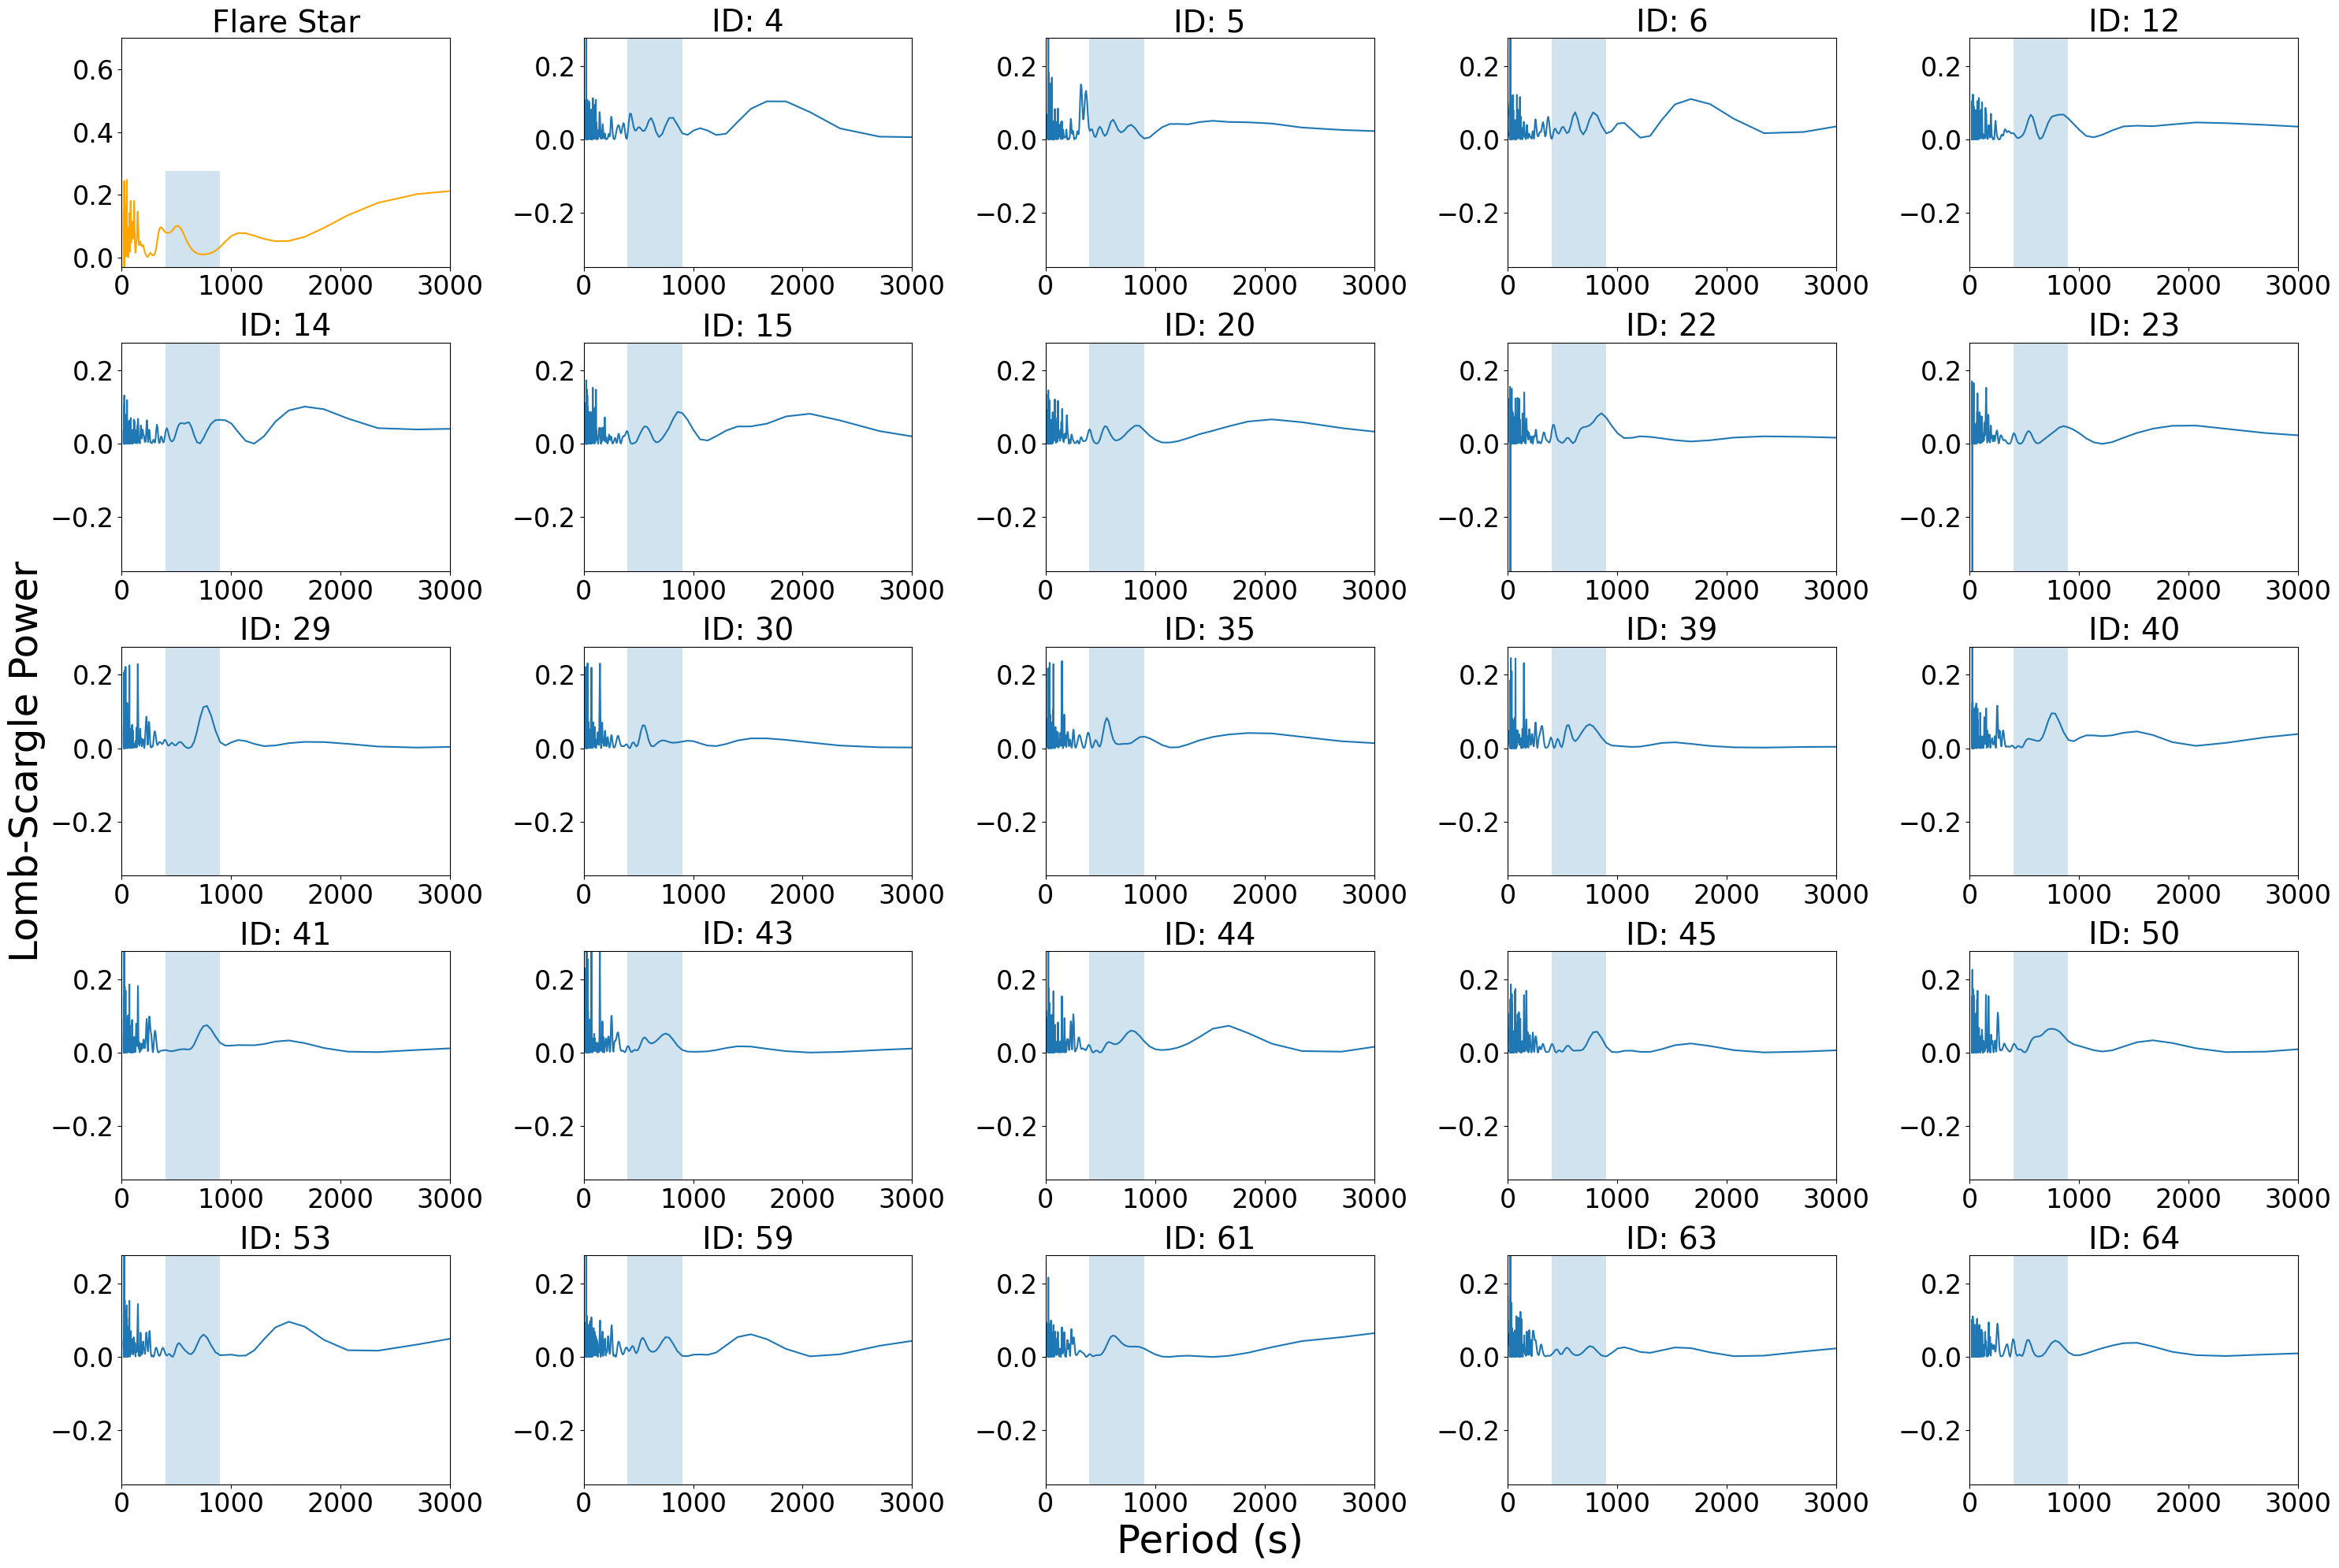

In [463]:
fig, ax = plt.subplots(5,5, figsize=(30,20))

freq, pow = LombScargle(dt_sec, shift_ras["new"][:,flr_id-1][t_index], err["new"][0][t_index]).autopower()

ax.flatten()[0].plot(1/freq,pow, c='orange')
ax.flatten()[0].set_xlim(0,3000)

c = 0

for i in range(1,len(ax.flatten())):

    freq, pow = LombScargle(dt_sec, shift_ras["new"][:,c][t_index], shift_raerrs["new"][:,c][t_index]).autopower()

    while (np.isnan(pow)).any():
        c += 1
        if c == flr_id - 1:
            c += 1
        freq, pow = LombScargle(dt_sec, shift_ras["new"][:,c][t_index], shift_raerrs["new"][:,c][t_index]).autopower()

    ax.flatten()[i].plot(1/freq, pow)
    ax.flatten()[i].set_xlim(0,3000)
    ax.flatten()[i].set_ylim(ax.flatten()[0].get_ylim())

    if i == 22:
        ax.flatten()[i].set_xlabel('Period (s)', fontsize=36)
    if i == 10:
        ax.flatten()[i].set_ylabel('Lomb-Scargle Power', fontsize=36)

    ax.flatten()[i].set_title('ID: {}'.format(c+1), fontsize=28)
    c += 1

for a in ax.flatten():
    a.tick_params(axis='both', labelsize=24)
    a.fill_betweenx(y = [a.get_ylim()[0], a.get_ylim()[1]], x1=400, x2=900, alpha=0.2)

ax.flatten()[0].set_ylim(-0.03, 0.7)
ax.flatten()[0].set_title('Flare Star', fontsize=28)

fig.tight_layout()

plt.savefig('Figures/dparffts.png', dpi=300, bbox_inches='tight')

## Converting $\alpha, \delta$ to $d_{\parallel}$

In [466]:
shift_ras["old"].shape, shift_decs["old"].shape, shift_ras["new"].shape, shift_decs["new"].shape, times.shape

((74, 110), (74, 110), (74, 110), (74, 110), (74,))

In [467]:
#Concat flare arrays to top 
'''
flr_ras = np.zeros_like(ras[:,0])
flr_decs = np.zeros_like(decs[:,0])
flr_raerrs = np.zeros_like(ras[:,0])
flr_decerrs = np.zeros_like(decs[:,0])

c = 0

for i, t in enumerate(times):
    
    if t_index[i]:

        flr_ras[i] = main_df['RA'][main_df['id'] == flr_id].iloc[c]
        flr_decs[i] = main_df['DEC'][main_df['id'] == flr_id].iloc[c]
        flr_raerrs[i] = main_df['RA_ERR'][main_df['id'] == flr_id].iloc[c]
        flr_decerrs[i] = main_df['DEC_ERR'][main_df['id'] == flr_id].iloc[c]
        c += 1
    else:

        flr_ras[i] = np.nan
        flr_decs[i] = np.nan
        flr_raerrs[i] = np.nan
        flr_decerrs[i] = np.nan

ras = np.concatenate((flr_ras[:,np.newaxis], ras), axis=1)
decs = np.concatenate((flr_decs[:,np.newaxis], decs), axis=1)
raerrs = np.concatenate((flr_raerrs[:,np.newaxis], raerrs), axis=1)
decerrs = np.concatenate((flr_decerrs[:,np.newaxis], decerrs), axis=1)
'''

"\nflr_ras = np.zeros_like(ras[:,0])\nflr_decs = np.zeros_like(decs[:,0])\nflr_raerrs = np.zeros_like(ras[:,0])\nflr_decerrs = np.zeros_like(decs[:,0])\n\nc = 0\n\nfor i, t in enumerate(times):\n    \n    if t_index[i]:\n\n        flr_ras[i] = main_df['RA'][main_df['id'] == flr_id].iloc[c]\n        flr_decs[i] = main_df['DEC'][main_df['id'] == flr_id].iloc[c]\n        flr_raerrs[i] = main_df['RA_ERR'][main_df['id'] == flr_id].iloc[c]\n        flr_decerrs[i] = main_df['DEC_ERR'][main_df['id'] == flr_id].iloc[c]\n        c += 1\n    else:\n\n        flr_ras[i] = np.nan\n        flr_decs[i] = np.nan\n        flr_raerrs[i] = np.nan\n        flr_decerrs[i] = np.nan\n\nras = np.concatenate((flr_ras[:,np.newaxis], ras), axis=1)\ndecs = np.concatenate((flr_decs[:,np.newaxis], decs), axis=1)\nraerrs = np.concatenate((flr_raerrs[:,np.newaxis], raerrs), axis=1)\ndecerrs = np.concatenate((flr_decerrs[:,np.newaxis], decerrs), axis=1)\n"

In [468]:
# converts celestial coordinates to PA - uses RA DEC RAerror and Dec error
pa_arr = {}
pa_arr["old"]= np.zeros_like(ras["old"])
pa_arr["new"]= np.zeros_like(ras["new"])
delpa_arr = {}
delpa_arr["old"] = np.zeros_like(ras["old"])
delpa_arr["new"] = np.zeros_like(ras["new"])

for i in range(ras["old"].shape[0]):
    for j in range(ras["old"].shape[1]):
        pa_arr["old"][i][j], delpa_arr["old"][i][j] = celest_to_pa(ras["old"][i,j], decs["old"][i,j], delra = raerrs["old"][i][j], 
                                                     deldec = decerrs["old"][i][j],
                                                     time = Time(times[i], format='mjd'), 
                                                     loc = EarthLocation.of_site('Cerro Tololo'))
for i in range(ras["new"].shape[0]):
    for j in range(ras["new"].shape[1]):
        pa_arr["new"][i][j], delpa_arr["new"][i][j] = celest_to_pa(ras["new"][i,j], decs["new"][i,j], delra = raerrs["new"][i][j], 
                                                     deldec = decerrs["new"][i][j],
                                                     time = Time(times[i], format='mjd'), 
                                                     loc = EarthLocation.of_site('Cerro Tololo'))

pa_arr_noflare, delpa_arr_noflare = {}, {}
pa_arr_noflare["old"] = np.delete(pa_arr["old"], FLAREINDX, 1)
pa_arr_noflare["new"] = np.delete(pa_arr["new"], FLAREINDX, 1)
delpa_arr_noflare["old"] = np.delete(delpa_arr["old"], FLAREINDX, 1)
delpa_arr_noflare["new"] = np.delete(delpa_arr["new"], FLAREINDX, 1)
pa_arr["old"].shape, delpa_arr["old"].shape, pa_arr_noflare["old"].shape, delpa_arr_noflare["old"].shape

((74, 110), (74, 110), (74, 109), (74, 109))

In [469]:
ddpar_arr["new"].shape

(74, 110)

In [470]:
dpar_arr, deldpar_arr, ddra_arr, dddec_arr, ddpar_arr = {},{},{},{},{}
dpar_arr["old"] = np.zeros_like(ras["old"])
deldpar_arr["old"] = np.zeros_like(ras["old"])
ddra_arr["old"] = np.zeros_like(ras["old"])
dddec_arr["old"] = np.zeros_like(ras["old"])
ddpar_arr["old"] = np.zeros_like(ras["old"])
dpar_arr["new"] = np.zeros_like(ras["new"])
deldpar_arr["new"] = np.zeros_like(ras["new"])
ddra_arr["new"] = np.zeros_like(ras["new"])
dddec_arr["new"] = np.zeros_like(ras["new"])
ddpar_arr["new"] = np.zeros_like(ras["new"])


for t in range(shift_ras["old"].shape[0]): #time
    for s in range(shift_ras["old"].shape[1]): #star
        if s == FLAREINDX:
            dpar_arr["old"][t][s], deldpar_arr["old"][t][s], ddra_arr["old"][t][s], dddec_arr["old"][t][s], ddpar_arr["old"][t][s] = dpar(shift_ras["old"][t,s] / 3600, shift_decs["old"][t,s] / 3600, 
                                                                                                       pa_arr["old"][t,s], 
                                delra = np.sqrt(err["old"][0][t]**2 + err["old"][0][0]**2) / D2ARCSEC, 
                                deldec = np.sqrt(err["old"][1][t]**2 + err["old"][1][0]**2) / D2ARCSEC, 
                                #delra = np.sqrt(raerrs[t,s]**2 + raerrs[0,s]**2), 
                                #deldec = np.sqrt(decerrs[t,s]**2 + decerrs[0,s]**2),
                                delpa2=delpa_arr["old"][t,s])
        else:
            dpar_arr["old"][t][s], deldpar_arr["old"][t][s], ddra_arr["old"][t][s], dddec_arr["old"][t][s], ddpar_arr["old"][t][s] = dpar(shift_ras["old"][t,s] / 3600, shift_decs["old"][t,s] / 3600, 
                                                                                                       pa_arr["old"][t,s], 
                                #delra = np.sqrt(err[0][t,s]**2 + raerrs[0,s]**2), deldec = np.sqrt(err[1][t,s]**2 + decerrs[0,s]**2), delpa2=delpa_arr[t,s])
                                delra = np.sqrt(raerrs["old"][t,s]**2 + raerrs["old"][0,s]**2), 
                                deldec = np.sqrt(decerrs["old"][t,s]**2 + decerrs["old"][0,s]**2), delpa2=delpa_arr["old"][t,s])

for t in range(shift_ras["new"].shape[0]): #time
    for s in range(shift_ras["new"].shape[1]): #star
        if s == FLAREINDX:
            dpar_arr["new"][t][s], deldpar_arr["new"][t][s], ddra_arr["new"][t][s], dddec_arr["new"][t][s], ddpar_arr["new"][t][s] = dpar(shift_ras["new"][t,s] / 3600, shift_decs["new"][t,s] / 3600, 
                                                                                                       pa_arr["new"][t,s], 
                                delra = np.sqrt(err["new"][0][t]**2 + err["new"][0][0]**2) / D2ARCSEC, 
                                deldec = np.sqrt(err["new"][1][t]**2 + err["new"][1][0]**2) / D2ARCSEC, 
                                #delra = np.sqrt(raerrs[t,s]**2 + raerrs[0,s]**2), 
                                #deldec = np.sqrt(decerrs[t,s]**2 + decerrs[0,s]**2),
                                delpa2=delpa_arr["new"][t,s])
        else:
            dpar_arr["new"][t][s], deldpar_arr["new"][t][s], ddra_arr["new"][t][s], dddec_arr["new"][t][s], ddpar_arr["new"][t][s] = dpar(shift_ras["new"][t,s] / 3600, shift_decs["new"][t,s] / 3600, 
                                                                                                       pa_arr["new"][t,s], 
                                #delra = np.sqrt(err[0][t,s]**2 + raerrs[0,s]**2), deldec = np.sqrt(err[1][t,s]**2 + decerrs[0,s]**2), delpa2=delpa_arr[t,s])
                                delra = np.sqrt(raerrs["new"][t,s]**2 + raerrs["new"][0,s]**2), 
                                deldec = np.sqrt(decerrs["new"][t,s]**2 + decerrs["new"][0,s]**2), delpa2=delpa_arr["new"][t,s])

#FBB acually you want to set relative to the first epoch setting the first epoch to 0 by subtracting it to everything!
#deldpar_arr[0,:] = 0.0 
dpar_arr["old"] = dpar_arr["old"]  - dpar_arr["old"][0,:] 
dpar_arr["new"] = dpar_arr["new"]  - dpar_arr["new"][0,:] 


dpar_arr_noflare, deldpar_arr_noflare = {}, {}
dpar_arr_noflare["old"] = np.delete(dpar_arr["old"], FLAREINDX, 1)
dpar_arr_noflare["new"] = np.delete(dpar_arr["new"], FLAREINDX, 1)
deldpar_arr_noflare["old"] = np.delete(deldpar_arr["old"], FLAREINDX, 1)
deldpar_arr_noflare["new"] = np.delete(deldpar_arr["new"], FLAREINDX, 1)
#np.save('Outdata/dpar_arr.npy', dpar_arr)

In [471]:
proj_angles, proj_angles_noflare = {},{}
proj_angles["old"] = np.rad2deg((np.pi * 0.5) - np.deg2rad(pa_arr["old"]) - np.arctan2(shift_decs["old"], shift_ras["old"]))
proj_angles_noflare["old"] = np.delete(proj_angles["old"], FLAREINDX, 1)
proj_angles["new"] = np.rad2deg((np.pi * 0.5) - np.deg2rad(pa_arr["new"]) - np.arctan2(shift_decs["new"], shift_ras["new"]))
proj_angles_noflare["new"] = np.delete(proj_angles["new"], FLAREINDX, 1)
proj_angles["old"].shape, proj_angles_noflare["old"].shape, proj_angles["new"].shape, proj_angles_noflare["new"].shape

((74, 110), (74, 109), (74, 110), (74, 109))

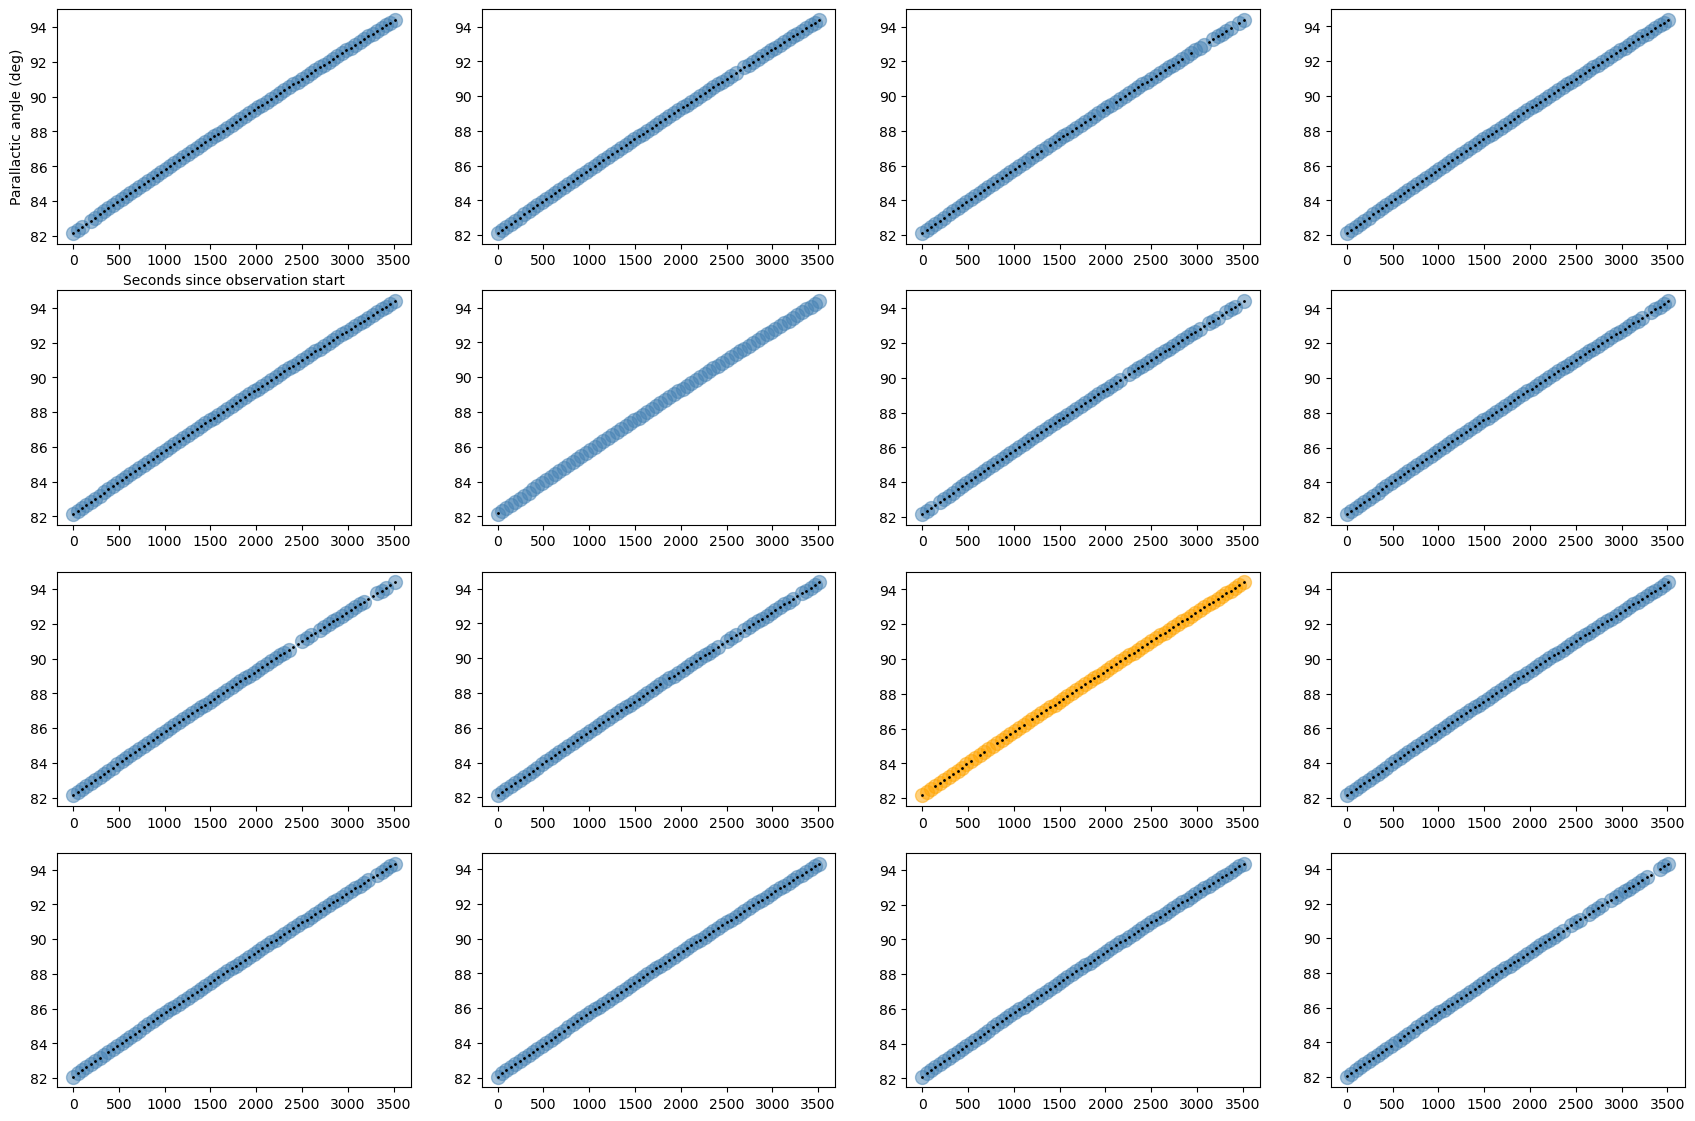

In [472]:
fig, ax = plt.subplots(4,4, figsize=(21,14))

for i in range(len(ax.flatten())):
    if i == FLAREINDX:
        color = 'orange'
    else:
        color = 'SteelBlue'
    ax.flatten()[i].errorbar(tSec, pa_arr["new"][:,i], yerr = delpa_arr["new"][:,i], color=color, marker='o', ms=10, alpha=0.5, ls='None')
    ax.flatten()[i].errorbar(tSec, pa_arr["old"][:,i], yerr = delpa_arr["old"][:,i], color='k', marker='o', ms=1, ls='None')

ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel('Parallactic angle (deg)');

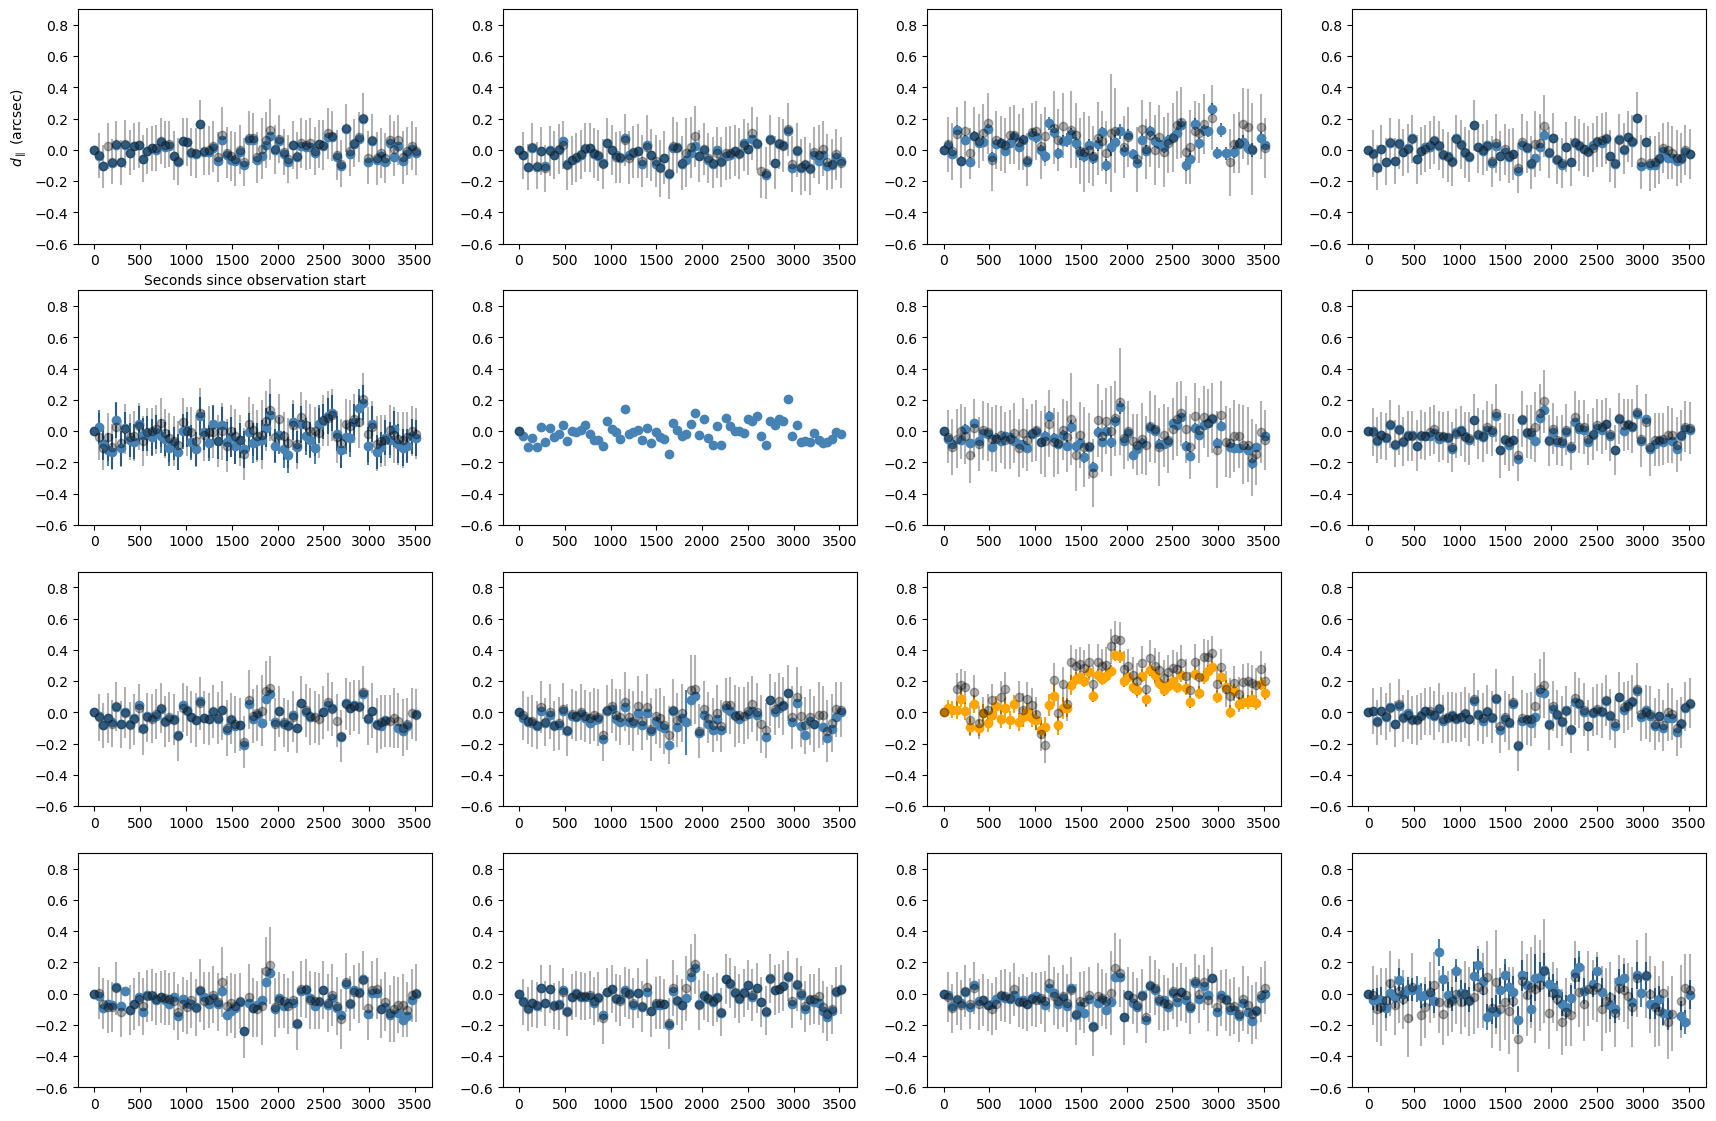

In [473]:
fig, ax = plt.subplots(4,4, figsize=(21,14))

for i in range(len(ax.flatten())):

    if i == flr_id-1:
        color = 'orange'
    else:
        color = 'SteelBlue'
   
    ax.flatten()[i].errorbar(tSec, dpar_arr["new"][:,i] * D2ARCSEC, yerr = deldpar_arr["new"][:,i] * D2ARCSEC, color=color, marker='o', ls='None')
    ax.flatten()[i].errorbar(tSec, dpar_arr["old"][:,i] * D2ARCSEC, yerr = deldpar_arr["old"][:,i] * D2ARCSEC, color='k', marker='o', ls='None', alpha=0.3)
    ax.flatten()[i].set_ylim(-0.6,0.9)

ax[0][0].set_xlabel('Seconds since observation start')
ax[0][0].set_ylabel(r'$d_{\parallel}$ (arcsec)');

### Converting $d_{\parallel}$ to $T_{eff}$

### Conditioning the $d_{\parallel}$ data

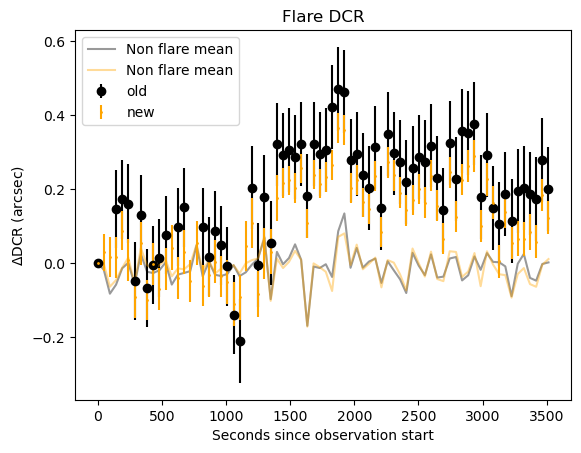

In [474]:
# FBB IMPORTANT! remove the flaring star from the average!!!
fig, ax = plt.subplots()
ax.errorbar(tSec, dpar_arr["old"][:,flr_id-1] * D2ARCSEC, yerr = deldpar_arr["old"][:,flr_id-1] * D2ARCSEC, 
            color='k', marker='o', ls='None', label="old")
ax.plot(tSec, np.nanmean(dpar_arr_noflare["old"], axis=1) * D2ARCSEC, c='k', alpha=0.4, label='Non flare mean')
ax.errorbar(tSec, dpar_arr["new"][:,flr_id-1] * D2ARCSEC, yerr = deldpar_arr["new"][:,flr_id-1] * D2ARCSEC, 
            color='orange', marker='o', ms=1, ls='None', label="new")
ax.plot(tSec, np.nanmean(dpar_arr_noflare["new"], axis=1) * D2ARCSEC, c='orange', alpha=0.4, label='Non flare mean')
ax.set_xlabel('Seconds since observation start')
ax.set_ylabel(r'$\Delta$DCR (arcsec)')
ax.set_title('Flare DCR')
ax.legend()

plt.savefig('Figures/raw_dpar.png', dpi = 300, bbox_inches='tight')

In [475]:
nfullstars_new = dpar_arr_noflare["new"].shape[1] - np.isnan(dpar_arr_noflare["new"]).sum(axis=0).max()
nfullstars_old = dpar_arr_noflare["old"].shape[1] - np.isnan(dpar_arr_noflare["old"]).sum(axis=0).max()
nfullstars_new, nfullstars_old

(35, 36)

In [476]:
(dpar_arr_noflare["new"].shape[1] - np.isnan(dpar_arr_noflare["new"]).sum(axis=0) == 109).sum()

34

In [477]:
fullstars_new = ((dpar_arr_noflare["new"].shape[1] - np.isnan(dpar_arr_noflare["new"]).sum(axis=0)) == nfullstars_new)
fullstars_old = ((dpar_arr_noflare["old"].shape[1] - np.isnan(dpar_arr_noflare["old"]).sum(axis=0)) == nfullstars_old)
dpar_arr_noflare_alldetected = {}

print(f"number of stars detected in all frames OLD", ((dpar_arr_noflare["old"].shape[1] - np.isnan(dpar_arr_noflare["old"]).sum(axis=0)) == 109).sum())
print(f"number of stars detected in all frames NEW", ((dpar_arr_noflare["new"].shape[1] - np.isnan(dpar_arr_noflare["new"]).sum(axis=0)) == 109).sum())
dpar_arr_noflare_alldetected["old"] = dpar_arr_noflare["old"][:,~fullstars_old]
dpar_arr_noflare_alldetected["new"] = dpar_arr_noflare["new"][:,~fullstars_new]

number of stars detected in all frames OLD 49
number of stars detected in all frames NEW 34


In [478]:
dpar_arr_noflare, dpar_arr_noflare_alldetected["old"]

({'old': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-9.23755743e-06, -9.30924841e-06,  1.02227023e-05, ...,
          -1.29722297e-05, -3.54499111e-06, -6.45776059e-05],
         [-2.94428220e-05, -3.03678405e-05, -2.37751319e-06, ...,
           8.90087685e-06,             nan, -3.43005425e-05],
         ...,
         [-1.79637554e-06, -2.49318149e-05,             nan, ...,
                      nan, -1.07631116e-05,  3.74050162e-05],
         [ 7.72157772e-06, -8.09163793e-06,  4.08197500e-05, ...,
           1.95574605e-05, -1.50618472e-05,  3.09907693e-05],
         [-1.46310510e-06, -2.29498883e-05,  3.73462264e-06, ...,
           2.09765791e-06, -1.20926487e-05, -2.69476184e-05]]),
  'new': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                      nan,             nan,             nan],
         [-1.02231092e-05, -8.22236861e-06,  7.38174386e-06, ...,
        

In [479]:
dpar_ma, dparerr_ma = {}, {}

dpar_ma["old"] = np.ma.MaskedArray(dpar_arr_noflare["old"], mask=np.isnan(dpar_arr_noflare["old"]))
dparerr_ma["old"] = dpar_ma["old"].std(axis=1)
dparerr_ma["old"] = dparerr_ma["old"].data.reshape((1,NDPS))



dpar_ma["new"] = np.ma.MaskedArray(dpar_arr_noflare["new"], mask=np.isnan(dpar_arr_noflare["new"]))
dparerr_ma["new"] = dpar_ma["new"].std(axis=1)
dparerr_ma["new"] = dparerr_ma["new"].data.reshape((1,NDPS))
dparerr_ma["old"].shape, dpar_ma["old"].shape, dparerr_ma["new"].shape, dpar_ma["new"].shape

((1, 74), (74, 109), (1, 74), (74, 109))

In [480]:
dpdiff = np.load(ROOTDIR + "DCRsum_m7.npy") #adding expected collective dDCR shift for average (solar) star
dpdiff

array([0.        , 0.00055053, 0.0011008 , 0.00165399, 0.00220441,
       0.00276216, 0.0033358 , 0.00390125, 0.00447929, 0.00503499,
       0.00562496, 0.00619865, 0.00677839, 0.00735662, 0.00793824,
       0.00852715, 0.00912897, 0.00972199, 0.01031712, 0.01091658,
       0.01151748, 0.01212101, 0.01272683, 0.01332155, 0.01393471,
       0.01454255, 0.01516964, 0.01581   , 0.01644463, 0.01708274,
       0.01770789, 0.01832252, 0.01894699, 0.01957796, 0.02022425,
       0.02088266, 0.02152876, 0.02217411, 0.02284572, 0.02350193,
       0.02416095, 0.02482861, 0.02549894, 0.0261701 , 0.02684514,
       0.02754263, 0.02822139, 0.02891467, 0.02960695, 0.03031366,
       0.03101602, 0.03173276, 0.03243695, 0.03314779, 0.03385765,
       0.0345833 , 0.03530397, 0.03604528, 0.03679093, 0.03751688,
       0.03824633, 0.03899994, 0.03974656, 0.04051191, 0.04126035,
       0.04200832, 0.04276815, 0.04354166, 0.04431749, 0.04508053,
       0.04585947, 0.04663907, 0.04742797, 0.04821747])

In [481]:
dpar_arr_noflare_alldetected["old"]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.23755743e-06, -9.30924841e-06,  1.02227023e-05, ...,
        -1.29722297e-05, -3.54499111e-06, -6.45776059e-05],
       [-2.94428220e-05, -3.03678405e-05, -2.37751319e-06, ...,
         8.90087685e-06,             nan, -3.43005425e-05],
       ...,
       [-1.79637554e-06, -2.49318149e-05,             nan, ...,
                    nan, -1.07631116e-05,  3.74050162e-05],
       [ 7.72157772e-06, -8.09163793e-06,  4.08197500e-05, ...,
         1.95574605e-05, -1.50618472e-05,  3.09907693e-05],
       [-1.46310510e-06, -2.29498883e-05,  3.73462264e-06, ...,
         2.09765791e-06, -1.20926487e-05, -2.69476184e-05]])

{'old':              mjd         time  dpar_raw  dpar_error  dpar_detrended  \
 0   57374.240660     0.000000  0.000000         NaN        0.000000   
 1   57374.241217    48.188013       NaN         NaN             NaN   
 2   57374.241772    96.133131       NaN         NaN             NaN   
 3   57374.242328   144.106382  0.146330    0.106152        0.203105   
 4   57374.242878   191.623585  0.172084    0.106152        0.181908   
 ..           ...          ...       ...         ...             ...   
 69  57374.279094  3320.683565  0.203083    0.112957        0.191382   
 70  57374.279650  3368.754328  0.187889    0.112957        0.234587   
 71  57374.280204  3416.591176  0.173068    0.112957        0.214476   
 72  57374.280761  3464.743816  0.277655    0.112957        0.280140   
 73  57374.281315  3512.654845  0.200520    0.112957        0.184555   
 
     dpar_detrended_err  dpar_smoothed  dparerr_smoothed     g_mag  \
 0                  NaN       0.181908          0.050041 

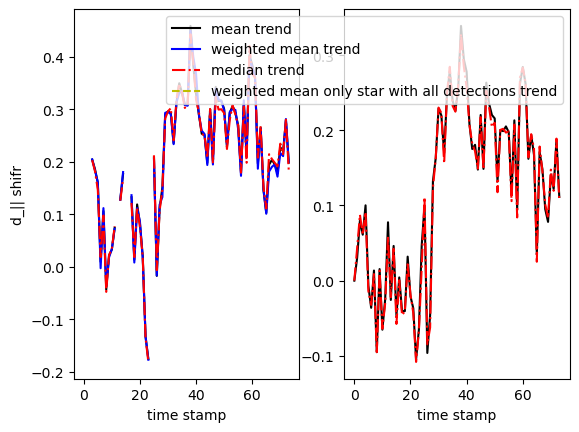

<Figure size 640x480 with 0 Axes>

In [484]:
dpar_raw = {}
dpar_raw["old"] = dpar_arr["old"][:,flr_id-1] * D2ARCSEC
dpar_raw["new"] = dpar_arr["new"][:,flr_id-1] * D2ARCSEC
dpar_trend_1 = {}
dpar_trend_1["old"] = np.nanmean(dpar_arr_noflare["old"], axis=1) * D2ARCSEC
dpar_trend_1["new"] = np.nanmean(dpar_arr_noflare["new"], axis=1) * D2ARCSEC

fig, axs = plt.subplots(1,2)
axs = axs.ravel()
fig = plt.figure()
axs[0].plot(dpar_raw["old"] - dpar_trend_1["old"], 'k', label="mean trend")
axs[1].plot(dpar_raw["new"] - dpar_trend_1["new"], 'k', label="mean trend")

dparerr_ma = {}
dparerr_ma["old"] = dpar_ma["old"].std(axis=1)
dparerr_ma["new"] = dpar_ma["new"].std(axis=1)

dpar_trend_2 = {}
dpar_trend_2["old"] = np.average(dpar_ma["old"], axis=1, weights=np.nanstd(dpar_arr_noflare["old"], axis=0), ) * D2ARCSEC
dpar_trend_2["new"] = np.average(dpar_ma["new"], axis=1, weights=np.nanstd(dpar_arr_noflare["new"], axis=0), ) * D2ARCSEC
axs[0].plot(dpar_raw["old"] - dpar_trend_2["old"], 'b', label="weighted mean trend")
axs[1].plot(dpar_raw["new"] - dpar_trend_2["new"], 'b', label="weighted mean trend")

dpar_trend_3 = {}
dpar_trend_3["old"] = np.nanmedian(dpar_arr_noflare["old"], axis=1) * D2ARCSEC
dpar_trend_3["new"] = np.nanmedian(dpar_arr_noflare["new"], axis=1) * D2ARCSEC
axs[0].plot(dpar_raw["old"] - dpar_trend_3["old"], 'r-.', label="median trend")
axs[1].plot(dpar_raw["new"] - dpar_trend_3["new"], 'r-.', label="median trend")

dpar_trend_4 = {}
dpar_trend_4["old"] = np.average(dpar_arr_noflare_alldetected["old"], axis=1, 
                                 weights=dpar_arr_noflare_alldetected["old"].std(axis=0)) * D2ARCSEC
dpar_trend_4["new"] = np.average(dpar_arr_noflare_alldetected["new"], axis=1, 
                                 weights=dpar_arr_noflare_alldetected["new"].std(axis=0)) * D2ARCSEC
axs[0].plot(dpar_raw["old"] - dpar_trend_4["old"], 'y--',
                       label="weighted mean only star with all detections trend")
axs[1].plot(dpar_raw["new"] - dpar_trend_4["new"], 'y--',
                       label="weighted mean only star with all detections trend")

axs[1].legend()
axs[0].set_xlabel('time stamp')
axs[1].set_xlabel('time stamp')
axs[0].set_ylabel('d_|| shifr')



dpar_subtracted, dparerr, dparerr_subtracted, dpar_smoothed, dpar_count, dparerr_smoothed, dpar_smoothedmean = {}, {}, {}, {}, {}, {}, {}
dpar_subtracted["old"] = dpar_raw["old"] - dpar_trend_3["old"] #+ dpdiff

dparerr["old"] = deldpar_arr["old"][:,flr_id-1] * D2ARCSEC
dparerr["old"][0] = np.nan

dparerr_subtracted["old"] = np.sqrt(dparerr["old"]**2 + np.nanstd(dpar_arr_noflare["old"], axis=1)**2)
window = 10

_ = pd.Series(dpar_subtracted["old"]).rolling(window, min_periods=1, center=True)

dpar_smoothed["old"] = _.median()
dpar_count["old"] = _.apply(lambda l: np.sum(~np.isnan(l)))
dparerr_smoothed["old"] = pd.Series(dparerr["old"]).rolling(window, min_periods=1, center=True).apply(lambda l: np.sqrt(np.nansum(l**2))) / dpar_count["old"]
dparerr_smoothed["old"] = pd.Series(dparerr["old"]).rolling(window, min_periods=1, center=True).apply(lambda l: np.sqrt(np.nansum(l**2))) / dpar_count["old"]

dpar_smoothedmean["old"] = _.mean()

flare_df = {}
flare_df["old"] = pd.DataFrame.from_dict({"mjd":times,
                                   "time": tSec,
                                        "dpar_raw": dpar_raw["old"], 
                                        "dpar_error": dparerr["old"],
                                        "dpar_detrended": dpar_subtracted["old"],
                                        "dpar_detrended_err": np.sqrt(dparerr["old"]**2 + np.nanstd(dpar_arr_noflare["old"])**2),
                                   #np.sqrt(dparerr**2 + np.nanstd(dpar_arr_noflare)**2),
                                        "dpar_smoothed":dpar_smoothed["old"],
                                        "dparerr_smoothed":dparerr_smoothed["old"],
                                        "g_mag": delta_g_mag["old"],
                                        "g_mag_error": delta_g_mag_err["old"],
                                   "ensamble_dpar": dpar_trend_3["old"]
                                   })

dpar_subtracted["new"] = dpar_raw["new"] - dpar_trend_3["new"] #+ dpdiff
dparerr["new"] = deldpar_arr["new"][:,flr_id-1] * D2ARCSEC
dparerr["new"][0] = np.nan
dparerr_subtracted["new"] = np.sqrt(dparerr["new"]**2 + np.nanstd(dpar_arr_noflare["new"], axis=1)**2)
window = 10
_ = pd.Series(dpar_subtracted["new"]).rolling(window, min_periods=1, center=True)
dpar_smoothed["new"] = _.median()
dpar_count["new"] = _.apply(lambda l: np.sum(~np.isnan(l)))
dparerr_smoothed["new"] = pd.Series(dparerr["new"]).rolling(window, min_periods=1, center=True).apply(lambda l: np.sqrt(np.nansum(l**2))) / dpar_count["old"]
dparerr_smoothed["new"] = pd.Series(dparerr["new"]).rolling(window, min_periods=1, center=True).apply(lambda l: np.sqrt(np.nansum(l**2))) / dpar_count["old"]

dpar_smoothedmean["new"] = _.mean()

flare_df["new"] = pd.DataFrame.from_dict({"mjd":times,
                                   "time": tSec,
                                        "dpar_raw": dpar_raw["new"], 
                                        "dpar_error": dparerr["new"],
                                        "dpar_detrended": dpar_subtracted["new"],
                                        "dpar_detrended_err": np.sqrt(dparerr["new"]**2 + np.nanstd(dpar_arr_noflare["new"])**2),
                                   #np.sqrt(dparerr**2 + np.nanstd(dpar_arr_noflare)**2),
                                        "dpar_smoothed":dpar_smoothed["new"],
                                        "dparerr_smoothed":dparerr_smoothed["new"],
                                        "g_mag": delta_g_mag["new"],
                                        "g_mag_error": delta_g_mag_err["new"],
                                   "ensamble_dpar": dpar_trend_3["new"]
                                   })
#if SAVE: 
    #flare_df["new"].to_csv("Outdata/flare_df["new"].csv")
flare_df

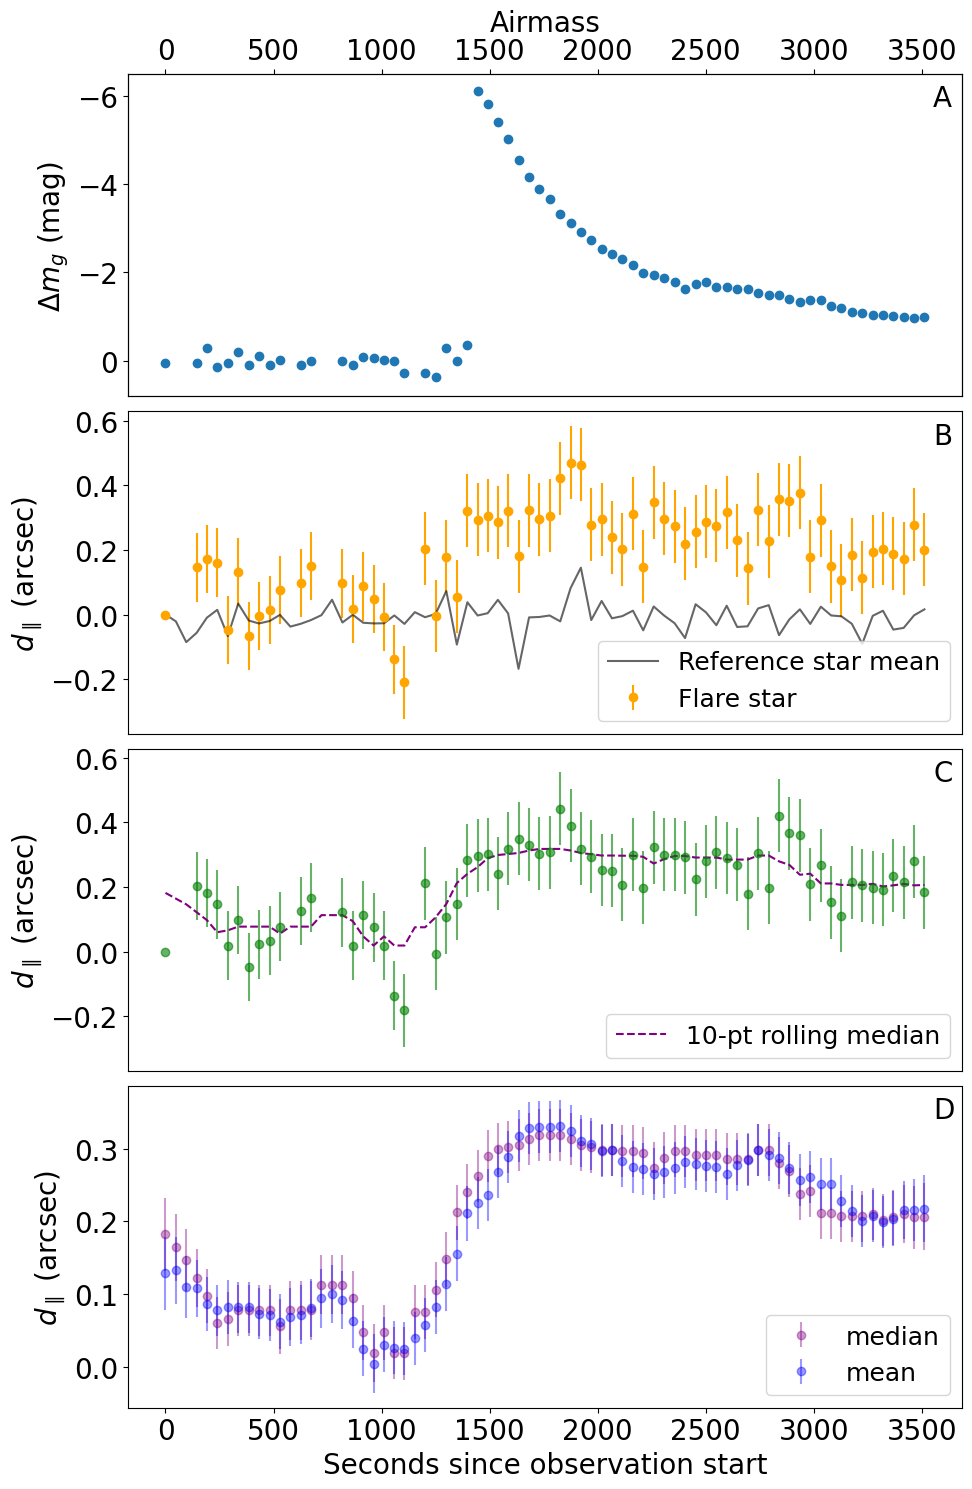

In [485]:

PLOT =True
if PLOT:
    fig, ax = plt.subplots(4,1, figsize=(10,15))

    ax[0].errorbar(flare_df["old"].time, flare_df["old"].g_mag, yerr = flare_df["old"].g_mag_error, 
                   color='C0', marker='o', ls='None')
    ax[0].set_ylabel(r'$\Delta m_g$ (mag)', fontsize=14)
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    ax[0].set_xticks([])

    ax[1].errorbar(flare_df["old"].time, flare_df["old"].dpar_raw, yerr = flare_df["old"].dpar_error, color='orange', marker='o', ls='None', label='Flare star')
    ax[1].plot(flare_df["old"].time, flare_df["old"].ensamble_dpar, c='k', alpha = 0.6, label='Reference star mean')
    #ax[0].set_xlabel('Seconds since observation start')
    ax[1].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[1].set_title(r'Flare Star $\Delta$DCR', fontsize=14)
    ax[1].legend(loc='lower right', fontsize=18)
    ax[1].set_xticks([])

    ax[2].errorbar(flare_df["old"].time, flare_df["old"].dpar_detrended, yerr = flare_df["old"].dpar_detrended_err, 
                color='green', marker='o', alpha=0.6, ls='None')
    ax[2].plot(flare_df["old"].time, flare_df["old"].dpar_smoothed, color='purple', ls='--', label='{}-pt rolling median'.format(window))

    #ax[2].set_title(r'Subtracted Flare Star $\Delta$DCR', fontsize=14)
    ax[2].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    ax[2].set_ylim(ax[1].get_ylim())
    ax[2].legend(loc='lower right', fontsize=18)
    ax[2].set_xticks([])

    ax[3].errorbar(flare_df["old"].time, flare_df["old"].dpar_smoothed, yerr = flare_df["old"].dparerr_smoothed, 
                   color='purple', alpha=0.4, ls='None', marker='o', label="median")
    ax[3].errorbar(flare_df["old"].time, dpar_smoothedmean["old"], yerr = flare_df["old"].dparerr_smoothed, 
                   color='blue', alpha=0.4, ls='None', marker='o', label="mean")
    ax[3].set_xlabel('Seconds since observation start', fontsize=14)
    ax[3].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[3].set_title(r'Subtracted + Smoothed Flare Star $\Delta$DCR', fontsize=14)
    ax[3].legend(loc='lower right', fontsize=18)
    
    subax0 = ax[0].twiny()
    subax0.set_xticks(ax[3].get_xticks())
    #subax0.set_xticklabels(np.round(AM[::8], decimals=2), fontsize=12)
    subax0.set_xlim(ax[0].get_xlim())
    subax0.set_xlabel('Airmass', fontsize=20)
    subax0.tick_params(labelsize=20)

    for axis, label in zip(ax, ['A', 'B', 'C', 'D']):
        axis.annotate(label, xy=(0.965,0.9), xycoords='axes fraction', fontsize=20)
        axis.tick_params(axis='both', labelsize=20)
        axis.set_xlabel(axis.get_xlabel(), fontsize=20)
        axis.set_ylabel(axis.get_ylabel(), fontsize=20)


    fig.tight_layout()

    plt.savefig('Figures/subtractedrolled_dpar.png', dpi = 300, bbox_inches='tight')

np.save('Outdata/dpar_smoothed.npy', dpar_smoothed)
np.save('Outdata/dparerr_smoothed.npy', dparerr_smoothed)

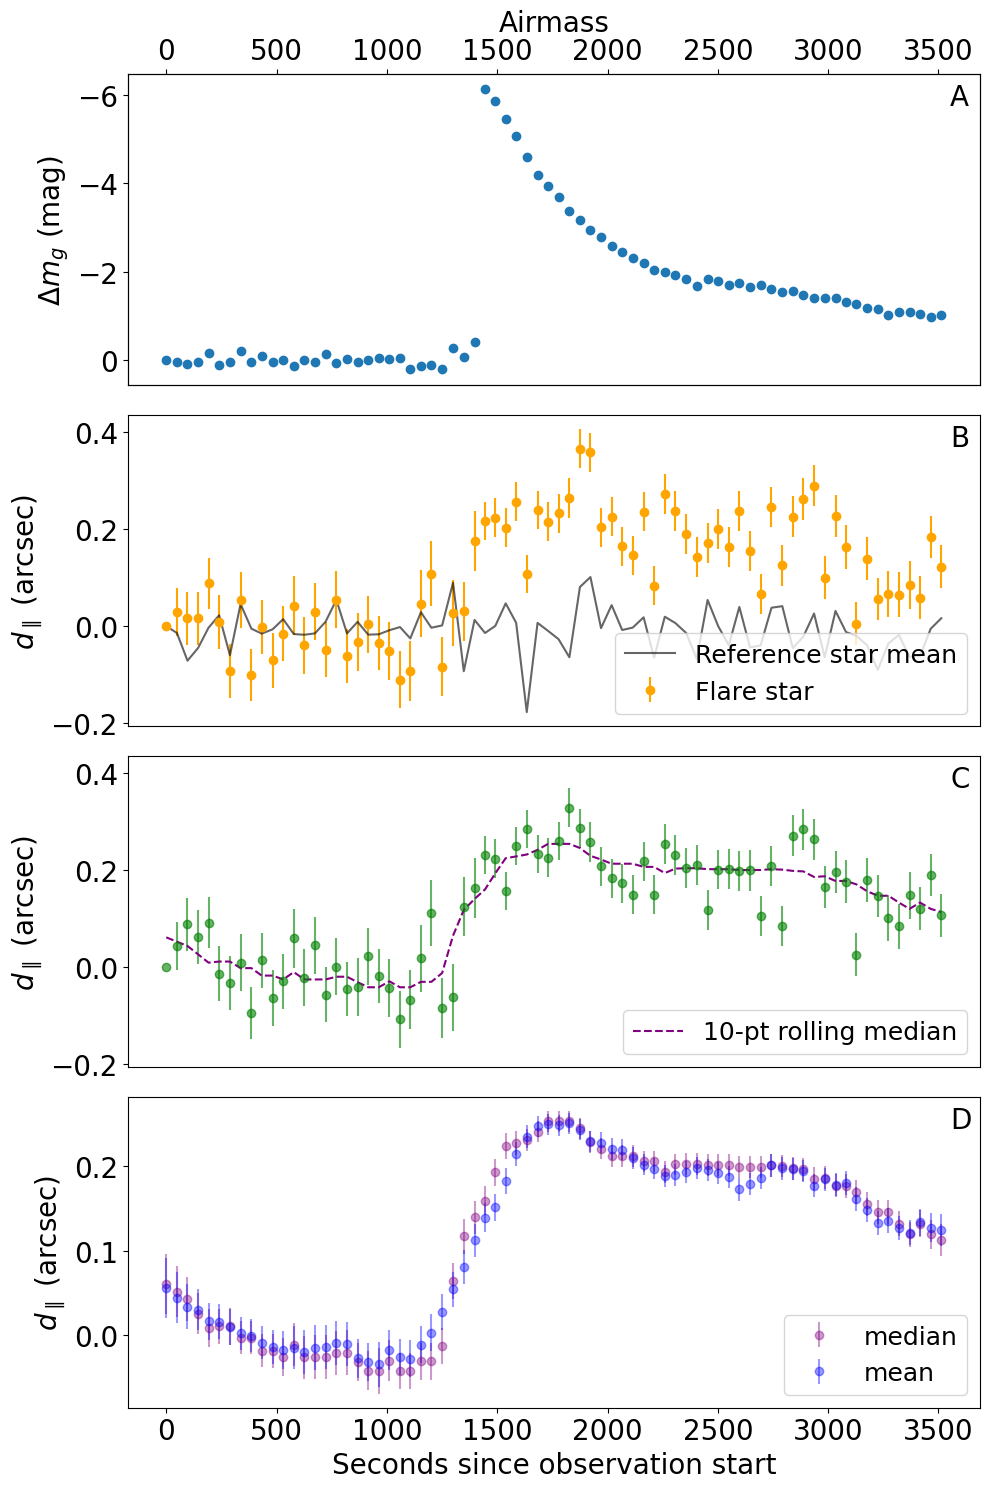

In [486]:

PLOT =True
if PLOT:
    fig, ax = plt.subplots(4,1, figsize=(10,15))

    ax[0].errorbar(flare_df["new"].time, flare_df["new"].g_mag, yerr = flare_df["new"].g_mag_error, 
                   color='C0', marker='o', ls='None')
    ax[0].set_ylabel(r'$\Delta m_g$ (mag)', fontsize=14)
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    ax[0].set_xticks([])

    ax[1].errorbar(flare_df["new"].time, flare_df["new"].dpar_raw, yerr = flare_df["new"].dpar_error, color='orange', marker='o', ls='None', label='Flare star')
    ax[1].plot(flare_df["new"].time, flare_df["new"].ensamble_dpar, c='k', alpha = 0.6, label='Reference star mean')
    #ax[0].set_xlabel('Seconds since observation start')
    ax[1].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[1].set_title(r'Flare Star $\Delta$DCR', fontsize=14)
    ax[1].legend(loc='lower right', fontsize=18)
    ax[1].set_xticks([])

    ax[2].errorbar(flare_df["new"].time, flare_df["new"].dpar_detrended, yerr = flare_df["new"].dpar_detrended_err, 
                color='green', marker='o', alpha=0.6, ls='None')
    ax[2].plot(flare_df["new"].time, flare_df["new"].dpar_smoothed, color='purple', ls='--', label='{}-pt rolling median'.format(window))

    #ax[2].set_title(r'Subtracted Flare Star $\Delta$DCR', fontsize=14)
    ax[2].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    ax[2].set_ylim(ax[1].get_ylim())
    ax[2].legend(loc='lower right', fontsize=18)
    ax[2].set_xticks([])

    ax[3].errorbar(flare_df["new"].time, flare_df["new"].dpar_smoothed, yerr = flare_df["new"].dparerr_smoothed, 
                   color='purple', alpha=0.4, ls='None', marker='o', label="median")
    ax[3].errorbar(flare_df["new"].time, dpar_smoothedmean["new"], yerr = flare_df["new"].dparerr_smoothed, 
                   color='blue', alpha=0.4, ls='None', marker='o', label="mean")
    ax[3].set_xlabel('Seconds since observation start', fontsize=14)
    ax[3].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[3].set_title(r'Subtracted + Smoothed Flare Star $\Delta$DCR', fontsize=14)
    ax[3].legend(loc='lower right', fontsize=18)
    
    subax0 = ax[0].twiny()
    subax0.set_xticks(ax[3].get_xticks())
    #subax0.set_xticklabels(np.round(AM[::8], decimals=2), fontsize=12)
    subax0.set_xlim(ax[0].get_xlim())
    subax0.set_xlabel('Airmass', fontsize=20)
    subax0.tick_params(labelsize=20)

    for axis, label in zip(ax, ['A', 'B', 'C', 'D']):
        axis.annotate(label, xy=(0.965,0.9), xycoords='axes fraction', fontsize=20)
        axis.tick_params(axis='both', labelsize=20)
        axis.set_xlabel(axis.get_xlabel(), fontsize=20)
        axis.set_ylabel(axis.get_ylabel(), fontsize=20)


    fig.tight_layout()

    plt.savefig('Figures/subtractedrolled_dpar.png', dpi = 300, bbox_inches='tight')

np.save('Outdata/dpar_smoothed.npy', dpar_smoothed)
np.save('Outdata/dparerr_smoothed.npy', dparerr_smoothed)

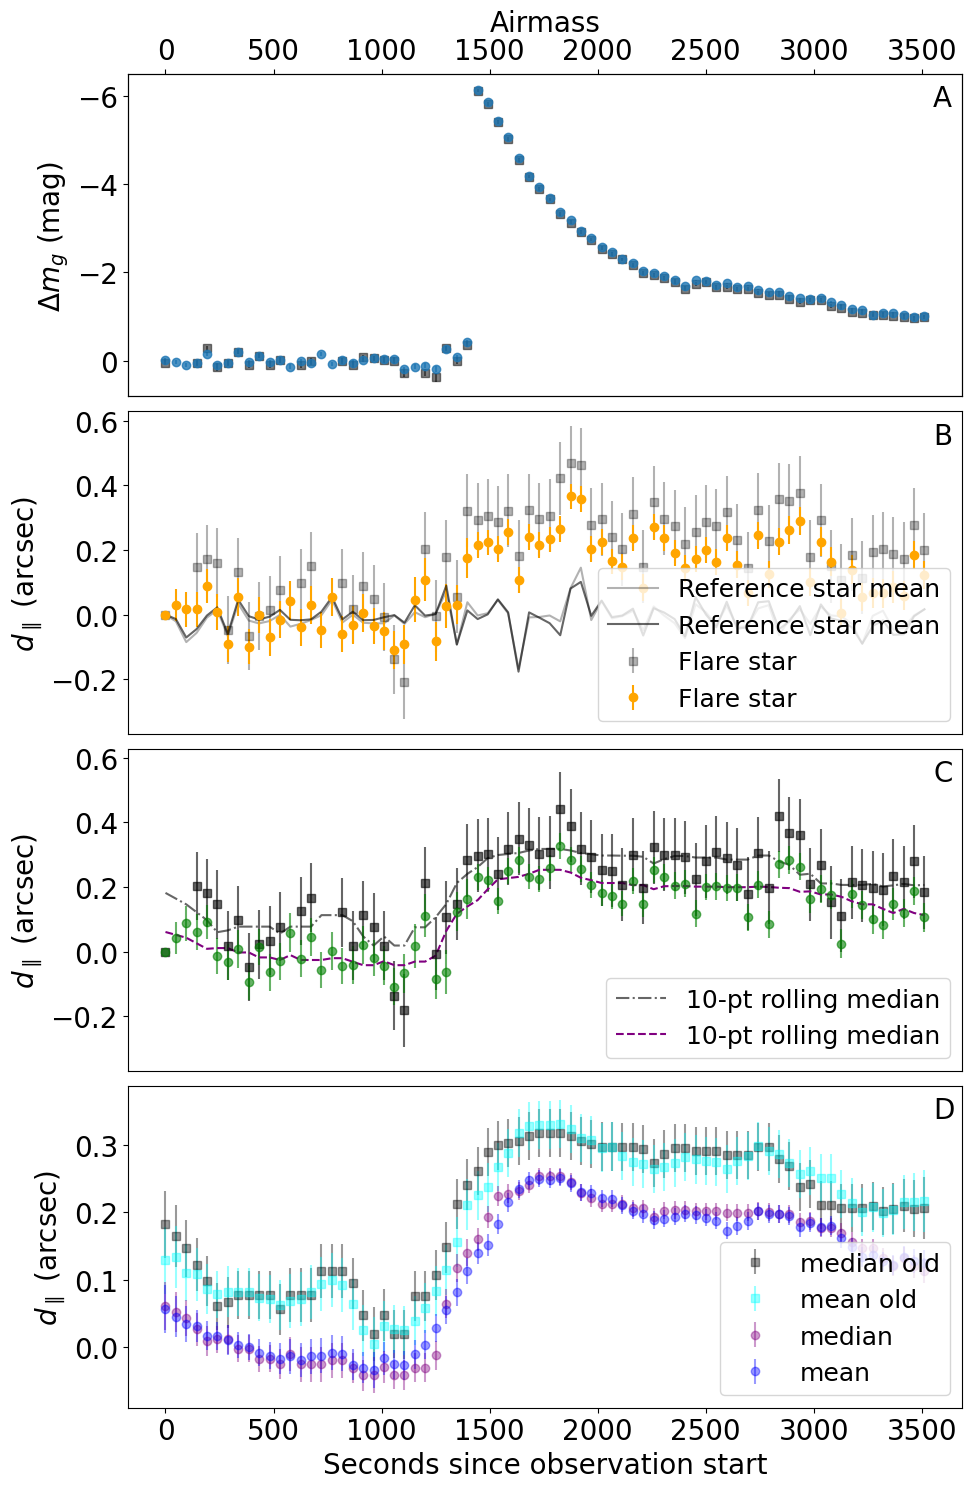

In [487]:

PLOT =True
if PLOT:
    fig, ax = plt.subplots(4,1, figsize=(10,15))
    ### old
    ax[0].errorbar(flare_df["old"].time, flare_df["old"].g_mag, yerr = flare_df["old"].g_mag_error, 
                   color='k', marker='s', ls='None', alpha=0.5)

    ax[1].errorbar(flare_df["old"].time, flare_df["old"].dpar_raw, yerr = flare_df["old"].dpar_error, alpha = 0.3, color='k', marker='s', ls='None', label='Flare star')
    ax[1].plot(flare_df["old"].time, flare_df["old"].ensamble_dpar, c='k', alpha = 0.3, label='Reference star mean')
    #ax[0].set_xlabel('Seconds since observation start')

    ax[2].errorbar(flare_df["old"].time, flare_df["old"].dpar_detrended, yerr = flare_df["old"].dpar_detrended_err, 
                color='k', marker='s', alpha=0.6, ls='None')
    ax[2].plot(flare_df["old"].time, flare_df["old"].dpar_smoothed, color='k', alpha=0.6, ls='-.', label='{}-pt rolling median'.format(window))

    #ax[2].set_title(r'Subtracted Flare Star $\Delta$DCR', fontsize=14)

    ax[3].errorbar(flare_df["old"].time, flare_df["old"].dpar_smoothed, yerr = flare_df["old"].dparerr_smoothed, 
                   color='k', alpha=0.4, ls='None', marker='s', label="median old")
    ax[3].errorbar(flare_df["old"].time, dpar_smoothedmean["old"], yerr = flare_df["old"].dparerr_smoothed, 
                   color='cyan', alpha=0.4, ls='None', marker='s', label="mean old")

    ### new
    ax[0].errorbar(flare_df["new"].time, flare_df["new"].g_mag, yerr = flare_df["new"].g_mag_error, 
                   color='C0', marker='o', ls='None', alpha=0.8)
    ax[0].set_ylabel(r'$\Delta m_g$ (mag)', fontsize=14)
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    ax[0].set_xticks([])

    ax[1].errorbar(flare_df["new"].time, flare_df["new"].dpar_raw, yerr = flare_df["new"].dpar_error, color='orange', marker='o', ls='None', label='Flare star')
    ax[1].plot(flare_df["new"].time, flare_df["new"].ensamble_dpar, c='k', alpha = 0.6, label='Reference star mean')
    #ax[0].set_xlabel('Seconds since observation start')
    ax[1].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[1].set_title(r'Flare Star $\Delta$DCR', fontsize=14)
    ax[1].legend(loc='lower right', fontsize=18)
    ax[1].set_xticks([])

    ax[2].errorbar(flare_df["new"].time, flare_df["new"].dpar_detrended, yerr = flare_df["new"].dpar_detrended_err, 
                color='green', marker='o', alpha=0.6, ls='None')
    ax[2].plot(flare_df["new"].time, flare_df["new"].dpar_smoothed, color='purple', ls='--', label='{}-pt rolling median'.format(window))

    #ax[2].set_title(r'Subtracted Flare Star $\Delta$DCR', fontsize=14)
    ax[2].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    ax[2].set_ylim(ax[1].get_ylim())
    ax[2].legend(loc='lower right', fontsize=18)
    ax[2].set_xticks([])

    ax[3].errorbar(flare_df["new"].time, flare_df["new"].dpar_smoothed, yerr = flare_df["new"].dparerr_smoothed, 
                   color='purple', alpha=0.4, ls='None', marker='o', label="median")
    ax[3].errorbar(flare_df["new"].time, dpar_smoothedmean["new"], yerr = flare_df["new"].dparerr_smoothed, 
                   color='blue', alpha=0.4, ls='None', marker='o', label="mean")
    ax[3].set_xlabel('Seconds since observation start', fontsize=14)
    ax[3].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[3].set_title(r'Subtracted + Smoothed Flare Star $\Delta$DCR', fontsize=14)
    ax[3].legend(loc='lower right', fontsize=18)
    
    subax0 = ax[0].twiny()
    subax0.set_xticks(ax[3].get_xticks())
    #subax0.set_xticklabels(np.round(AM[::8], decimals=2), fontsize=12)
    subax0.set_xlim(ax[0].get_xlim())
    subax0.set_xlabel('Airmass', fontsize=20)
    subax0.tick_params(labelsize=20)

    for axis, label in zip(ax, ['A', 'B', 'C', 'D']):
        axis.annotate(label, xy=(0.965,0.9), xycoords='axes fraction', fontsize=20)
        axis.tick_params(axis='both', labelsize=20)
        axis.set_xlabel(axis.get_xlabel(), fontsize=20)
        axis.set_ylabel(axis.get_ylabel(), fontsize=20)


    fig.tight_layout()

    plt.savefig('Figures/subtractedrolled_dpar.png', dpi = 300, bbox_inches='tight')

np.save('Outdata/dpar_smoothed.npy', dpar_smoothed)
np.save('Outdata/dparerr_smoothed.npy', dparerr_smoothed)

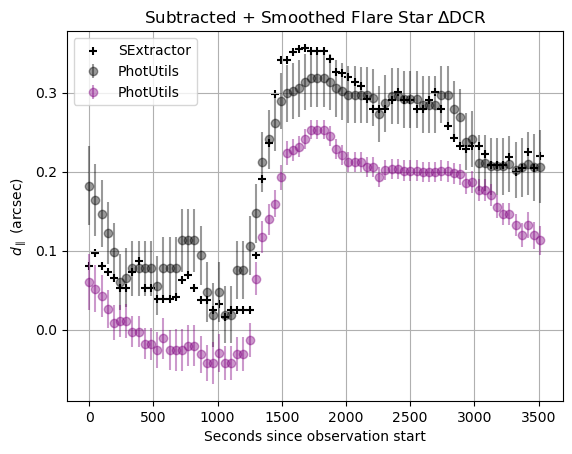

In [488]:
dparsex = np.load('Outdata/dpar_sextractor.npy')

plt.errorbar(tSec, dpar_smoothed["old"], yerr = dparerr_smoothed["old"], color='k', alpha=0.4, ls='None', marker='o', label='PhotUtils')
plt.errorbar(tSec, dpar_smoothed["new"], yerr = dparerr_smoothed["new"], color='purple', alpha=0.4, ls='None', marker='o', label='PhotUtils')
plt.scatter(tSec, dparsex, color='k', ls='None', marker='+', label='SExtractor', zorder=0)

plt.xlabel('Seconds since observation start')
plt.ylabel(r'$d_\parallel$ (arcsec)')
plt.title(r'Subtracted + Smoothed Flare Star $\Delta$DCR')
plt.grid()
plt.legend()

In [490]:
##Saving data required for analysis to Outdata
#.npy
np.save('Outdata/dpar_arr.npy', dpar_arr)
np.save('Outdata/dpar_raw.npy', dpar_raw)
np.save('Outdata/dpar_subtracted.npy', dpar_subtracted)
np.save('Outdata/dparerr.npy', dparerr)
np.save('Outdata/delta_g_mag.npy', delta_g_mag)
np.save('Outdata/delta_g_mag_err.npy', delta_g_mag_err)
np.save('Outdata/times.npy', times)
